<a href="https://colab.research.google.com/github/jihye-kim11/Credit-Card-Delinquency-Predictive-Model-/blob/master/AI_02_%EA%B9%80%EC%A7%80%ED%98%9C_Section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

%%capture
import sys
 
if 'google.colab' in sys.modules:

   !pip install category_encoders==2.*
   !pip install pandas-profiling==2.*
   !pip install --upgrade sckit-learn
   !pip install eli5
   !pip install pdpbox
   !pip install shap
   !pip3 install lightgbm
 
 
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from pandas_profiling import ProfileReport

from category_encoders import OrdinalEncoder, TargetEncoder

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, plot_confusion_matrix, classification_report

from scipy.stats import uniform, randint

from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

import shap

from lightgbm import LGBMClassifier

In [ ]:
!mkdir data

In [ ]:
!cp "/content/drive/MyDrive/신용카드 연체 예측 데이터/train.csv" "/content/data/train.csv"
!cp "/content/drive/MyDrive/신용카드 연체 예측 데이터/test.csv" "/content/data/test.csv"
!cp "/content/drive/MyDrive/신용카드 연체 예측 데이터/sample_submission.csv" "/content/data/sample_submission.csv"

In [ ]:
train = pd.read_csv("/content/data/train.csv")
test = pd.read_csv("/content/data/test.csv")

In [ ]:
train.shape

(26457, 20)

In [ ]:
data = train

#**Dataset :신용카드 사용자 데이터**

source: https://dacon.io/competitions/official/235713/overview/description/   

###-데이터 선정 이유
코로나가 장기화되며 은행들이 손해를 최소화하기위해 신용등급 평가 기준을 재조정하며 신용카드 발급 기준을 향상시키고있다.   
발급 기준의 정확도를 향상시키기 위해 신용카드 신청자가 제출찬 개인 신상정보를 분석하고 주어진 데이터와 대금 연체 정도의 관계성을 파악해 더 정확한 평가 기준을 완성시키고자한다.   

###-데이터:   
신용카드 사용자들의 개인 신상정보를 사용해 분석합니다.   

###-분석목표:   
신용카드 사용자들의 개인 신상정보를 사용해 사용자의 대금 연체 정도를 예측할 수 있는 인공지능 알고리즘을 개발하자.   

###Features


```
index

gender: 성별

car: 차량 소유 여부

reality: 부동산 소유 여부

child_num: 자녀 수

income_total: 연간 소득

income_type: 소득 분류
['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']

edu_type: 교육 수준
['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']

family_type: 결혼 여부
['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']

house_type: 생활 방식
['Municipal apartment', 'House / apartment', 'With parents','Co-op apartment', 'Rented apartment', 'Office apartment']

DAYS_BIRTH: 출생일
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미

DAYS_EMPLOYED: 업무 시작일
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미
양수 값은 고용되지 않은 상태를 의미함

FLAG_MOBIL: 핸드폰 소유 여부

work_phone: 업무용 전화 소유 여부

phone: 전화 소유 여부

email: 이메일 소유 여부

occyp_type: 직업 유형													

family_size: 가족 규모

begin_month: 신용카드 발급 월
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미

credit: 사용자의 신용카드 대금 연체를 기준의 신용도
=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함

	
```



#EDA

우선 데이터의 구성을 알아보기 위해 프로파일링을 진행하였다.

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

####warning


1.   FLAG_MOBIL has constant value "1"   
 :FLAG_MOBIL은 핸드폰 소유 여부를 나타내는 데이터이다. 이 데이터는 경우의수가 1가지이므로 삭제해주도록 하자.
2.   occyp_type has 8171 (30.9%) missing values
3.   df_index has unique values : 인덱스는 후에 지워주자
4.   child_num has 18340 (69.3%) zeros


###missing value는 occyp_type말고는 없다.

###**Target: 신용 등급의 비율(credit)**
credit: 사용자의 신용카드 대금 연체 기준의 신용도

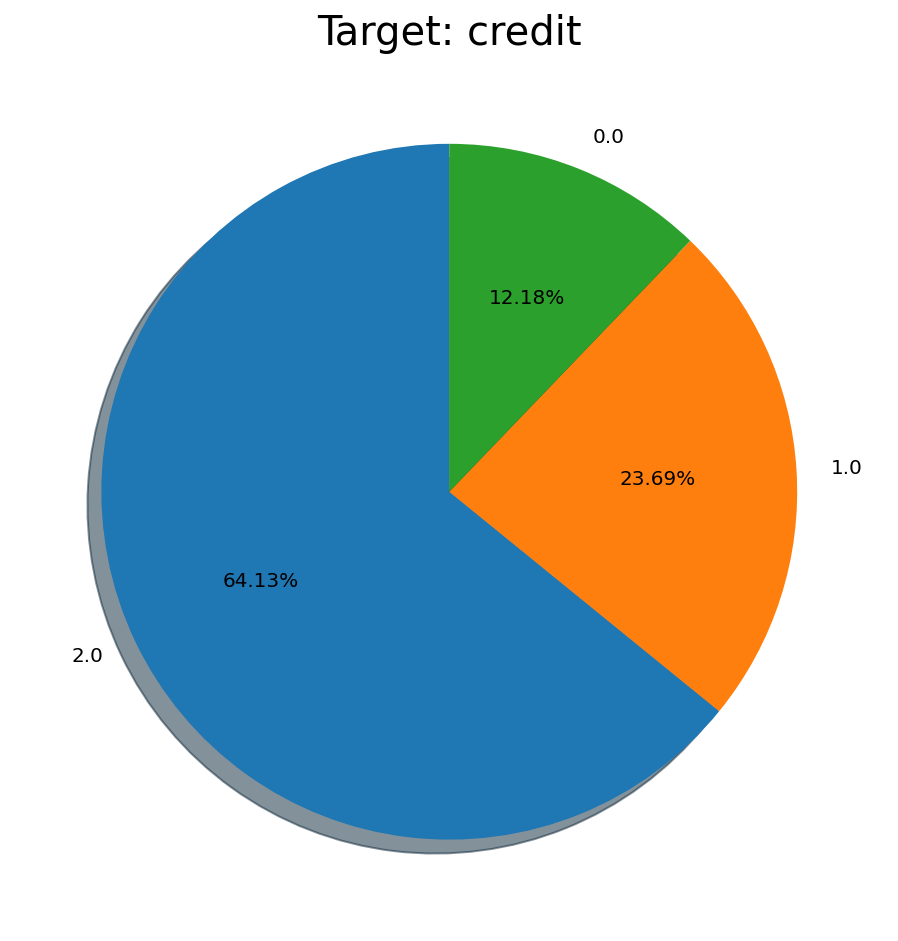

In [ ]:
plt.subplots(figsize = (8,8))
plt.pie(train['credit'].value_counts(), labels = train['credit'].value_counts().index, 
        autopct="%.2f%%", shadow = True, startangle = 90)
plt.title('Target: credit', size=20)
plt.show()

낮을수록 높은 신용의 신용카드 사용자를 의미한다. 따라서 신용이 낮은 사용자의 비율이 높다는 것을 확인할 수 있다.   

###**자녀 수 별 신용등급(child_num)**

In [ ]:
train[['child_num','credit']].groupby(['child_num']).mean()

,credit
child_num,
0,1.520829
1,1.502971
2,1.546571
3,1.552288
4,1.404255
5,1.000000
7,2.000000
14,2.000000
19,2.000000


In [ ]:
train.groupby(['child_num', 'credit'])['credit'].count()

child_num  credit
0          0.0        2233
           1.0        4322
           2.0       11785
1          0.0         682
           1.0        1313
           2.0        3391
2          0.0         268
           1.0         535
           2.0        1559
3          0.0          29
           1.0          79
           2.0         198
4          0.0           8
           1.0          12
           2.0          27
5          0.0           2
           1.0           6
           2.0           2
7          2.0           2
14         2.0           3
19         2.0           1
Name: credit, dtype: int64

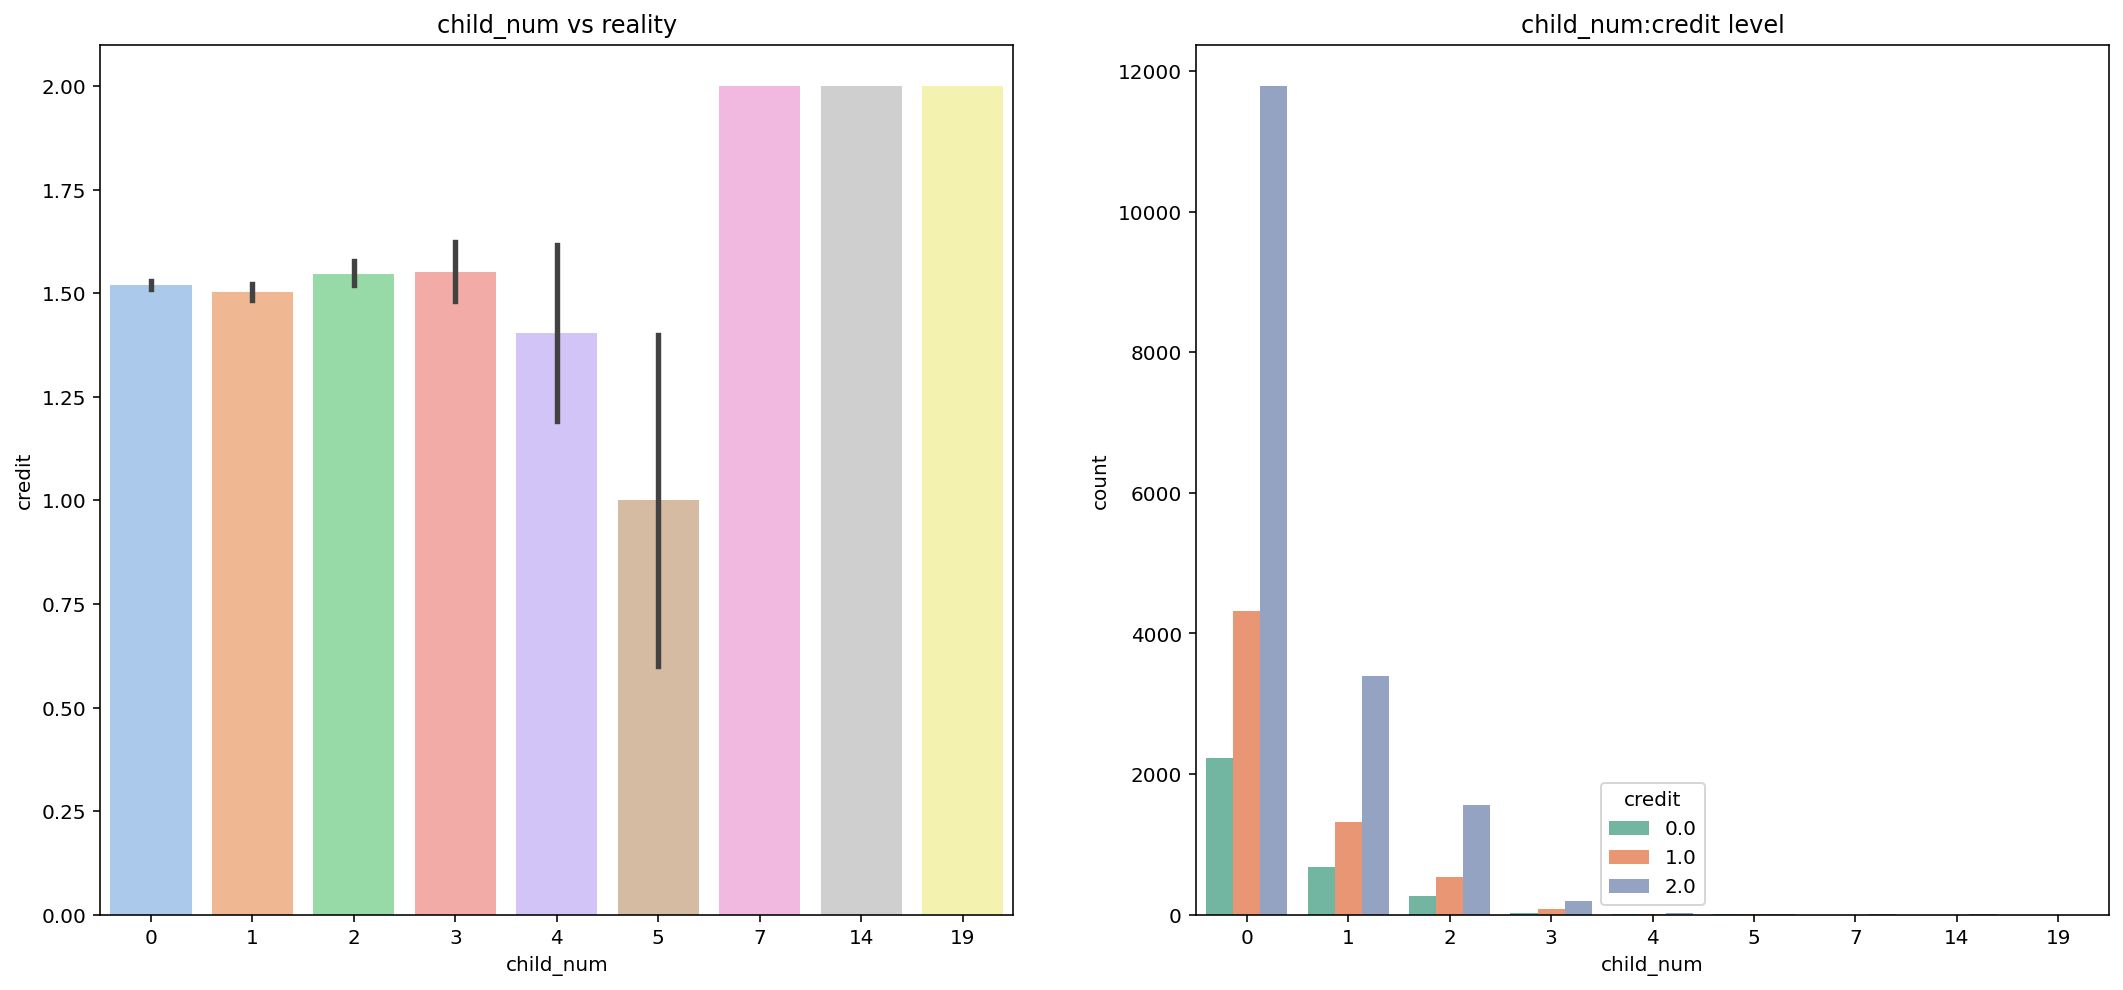

In [ ]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.set_palette("pastel")
sns.barplot(data=train, x="child_num", y="credit",ax=ax[0])
ax[0].set_title('child_num vs reality')
sns.countplot('child_num',hue='credit',data=train,ax=ax[1], palette='Set2')
ax[1].set_title('child_num:credit level')
plt.show()

child_num 데이터는 실질적으로는 0,1,2,3,밖에 없다. 이는 이 데이터가 중국에서 조사한 데이터인데 중국의 산아제한정책때문에 이러한 데이터 형태가 발생한 듯 하다.

2보다 큰 데이터는 매우 적어 무의미하므로 2보다 큰 경우 2로 수정해주자.

In [ ]:
data.loc[data['child_num'] > 2, 'child_num'] = 2

###**가족규모별신용등급(family_size)**

In [ ]:
train.groupby(['family_size', 'credit'])['credit'].count()

family_size  credit
1.0          0.0        605
             1.0       1318
             2.0       3186
2.0          0.0       1720
             1.0       3249
             2.0       9137
3.0          0.0        610
             1.0       1088
             2.0       2934
4.0          0.0        251
             1.0        520
             2.0       1489
5.0          0.0         27
             1.0         74
             2.0        190
6.0          0.0          7
             1.0         12
             2.0         25
7.0          0.0          2
             1.0          6
             2.0          1
9.0          2.0          2
15.0         2.0          3
20.0         2.0          1
Name: credit, dtype: int64

In [ ]:
train_0 = train[train['credit']==0.0]
train_1 = train[train['credit']==1.0]
train_2 = train[train['credit']==2.0]

def num_plot(column):
  sns.set_palette("tab10")
  fig, axes = plt.subplots(1, 3, figsize=(16, 6))

  sns.distplot(train_0[column],
                ax = axes[0])
  axes[0].tick_params(labelsize=12)
  axes[0].set_title('credit = 0')
  axes[0].set_ylabel('count')

  sns.distplot(train_1[column],
                ax = axes[1])
  axes[1].tick_params(labelsize=12)
  axes[1].set_title('credit = 1')
  axes[1].set_ylabel('count')

  sns.distplot(train_2[column],
                ax = axes[2])
  axes[2].tick_params(labelsize=12)
  axes[2].set_title('credit = 2')
  axes[2].set_ylabel('count')
  plt.subplots_adjust(wspace=0.3, hspace=0.3)

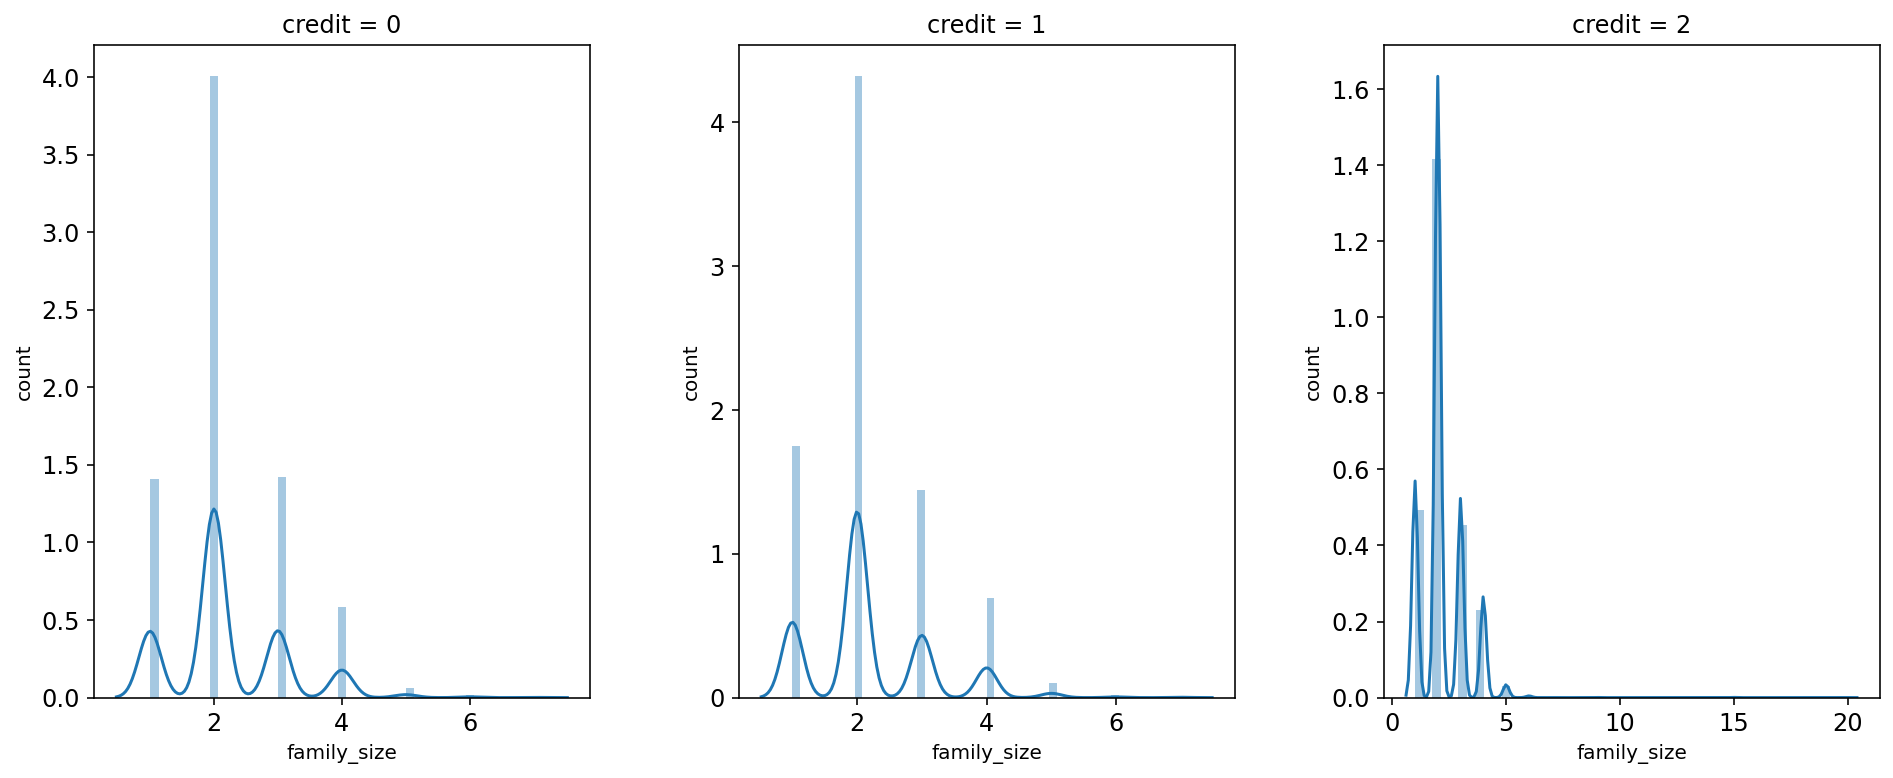

In [ ]:
num_plot("family_size")

다음으로 가족규모 데이터 입니다.
데이터는 1부터 20까지의 데이터로 이루어져있지만 5이하의 데이터에 값들이 몰려있습니다.
따라서 이전과 마찬가지로 5보다 큰 데이터는 매우 적어 무의미하므로 데이터 가공 단계에서 5로 수정해주기로 하였습니다.


In [ ]:
data.loc[data['family_size'] > 5, 'family_size'] = 5

In [ ]:
data[['family_size','credit']].groupby(['family_size']).mean()

,credit
family_size,
1.0,1.505187
2.0,1.525805
3.0,1.501727
4.0,1.547788
5.0,1.531429


In [ ]:
data.groupby(['family_size', 'credit'])['credit'].count()

family_size  credit
1.0          0.0        605
             1.0       1318
             2.0       3186
2.0          0.0       1720
             1.0       3249
             2.0       9137
3.0          0.0        610
             1.0       1088
             2.0       2934
4.0          0.0        251
             1.0        520
             2.0       1489
5.0          0.0         36
             1.0         92
             2.0        222
Name: credit, dtype: int64

###**핸드폰 소유 여부 별 신용등급(FLAG_MOBIL)**

In [ ]:
train[['FLAG_MOBIL','credit']].groupby(['FLAG_MOBIL']).mean()

,credit
FLAG_MOBIL,
1,1.51956


In [ ]:
train.groupby(['FLAG_MOBIL', 'credit'])['credit'].count()

FLAG_MOBIL  credit
1           0.0        3222
            1.0        6267
            2.0       16968
Name: credit, dtype: int64

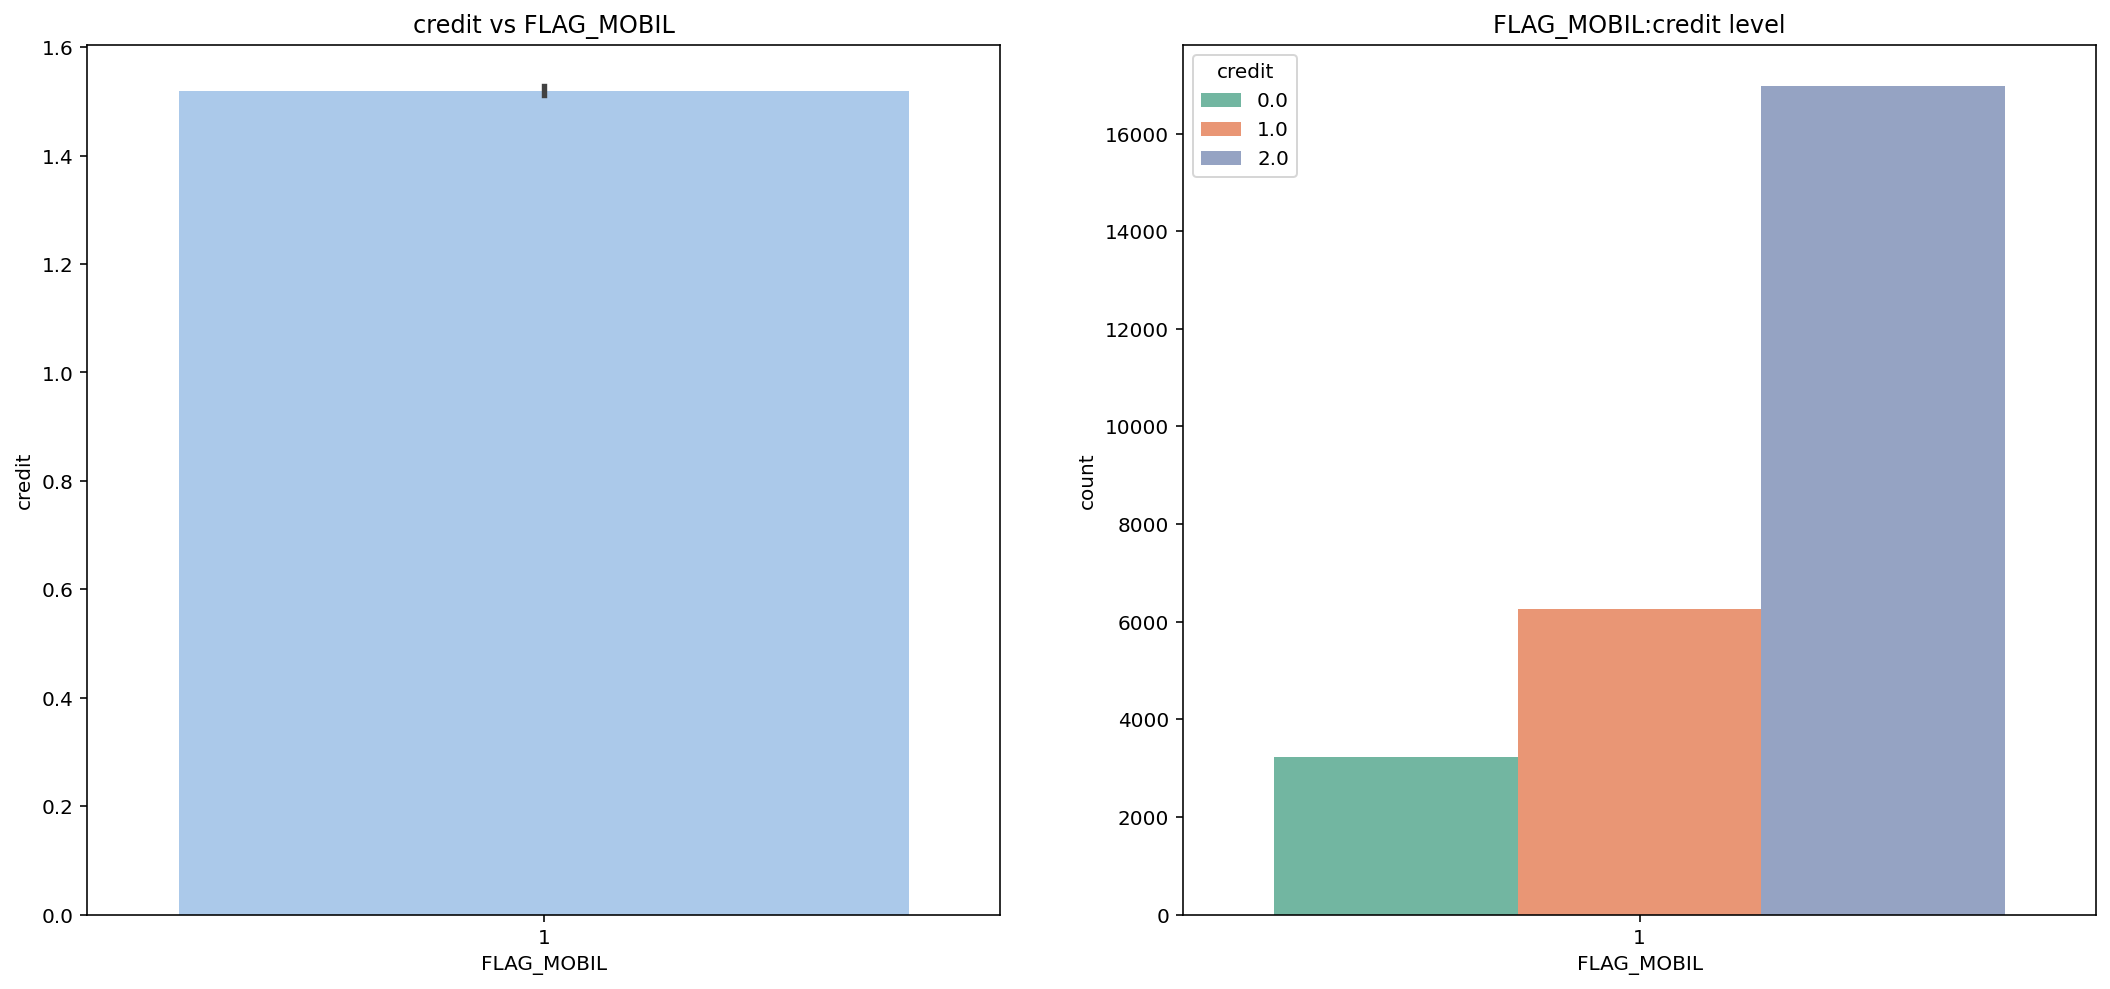

In [ ]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.set_palette("pastel")
sns.barplot(data=train, x="FLAG_MOBIL", y="credit",ax=ax[0])
ax[0].set_title('credit vs FLAG_MOBIL')
sns.countplot('FLAG_MOBIL',hue='credit',data=train,ax=ax[1], palette='Set2')
ax[1].set_title('FLAG_MOBIL:credit level')
plt.show()

*   수집된 데이터 중 핸드폰을 소유하지 않은 사람의 데이터는 없었다. 후에 삭제하고 진행해도 문제없을듯하다.

In [ ]:
data=data.drop('FLAG_MOBIL',axis=1)

###**신용카드 발급 월별 신용등급(begin_month)**
현재 음수이므로 양수로 변경

In [ ]:
data[['begin_month']].describe()

,begin_month
count,26457.000000
mean,-26.123294
std,16.559550
min,-60.000000
25%,-39.000000
50%,-24.000000
75%,-12.000000
max,0.000000


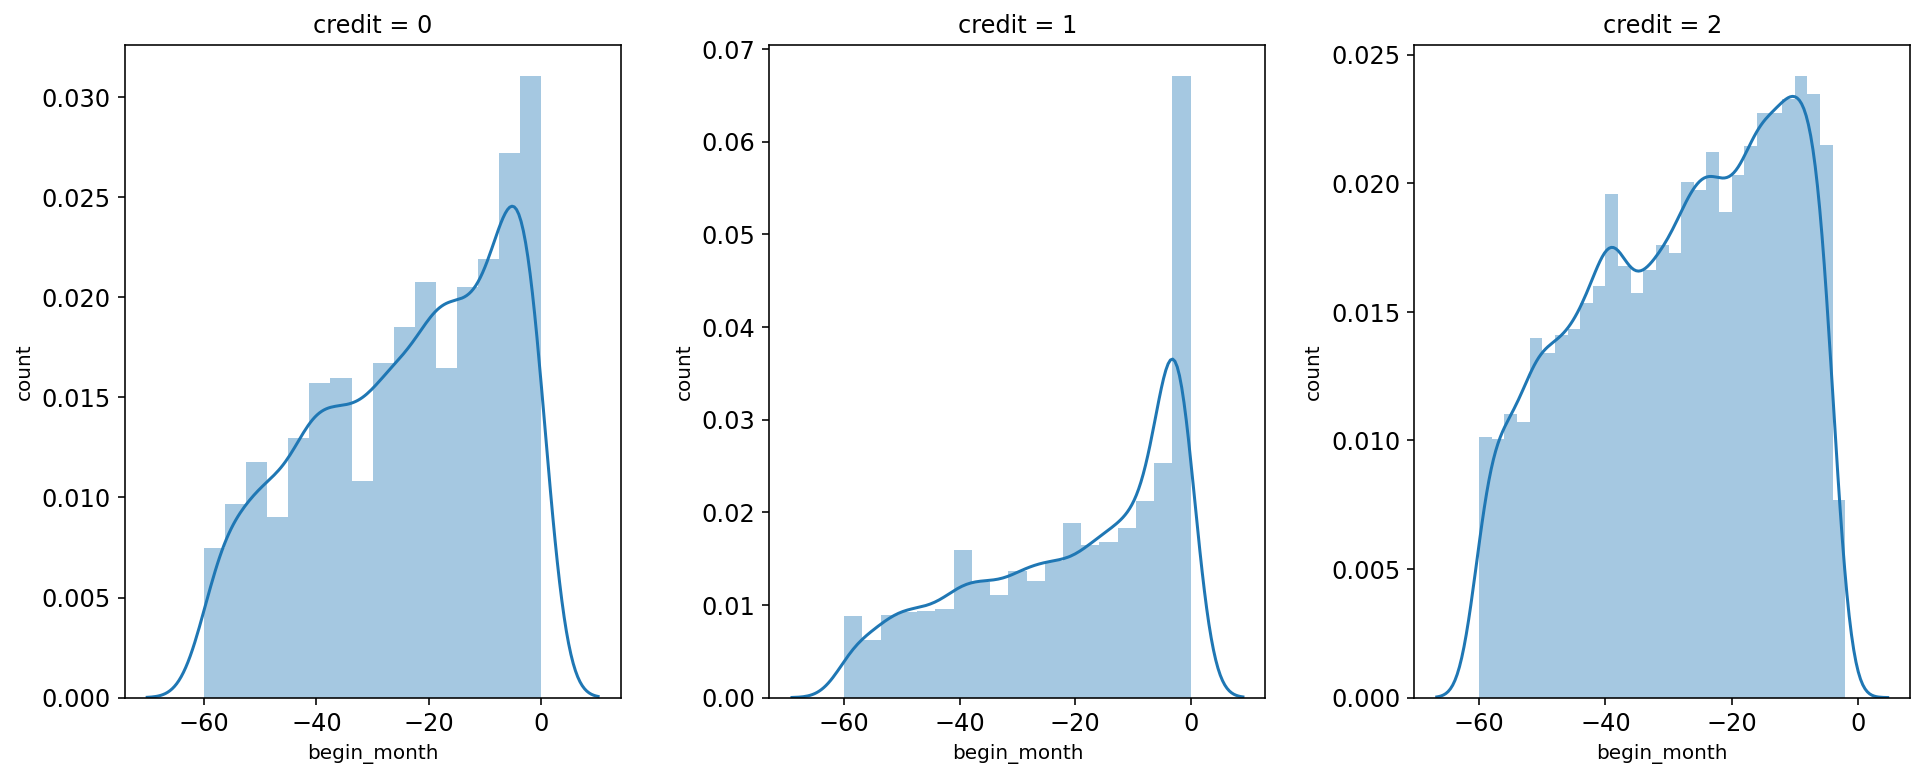

In [ ]:
num_plot("begin_month")

현재 begin_month는 데이터 수집 당시를 0으로 잡고 역으로 월을 세서 신용카드를 발급받은지 얼마나 되었는지를 보여주고 있다.   
즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미한다.   
음수는 분석하기 복잡하므로 '-1'을 곱하여 양수로 변경해주자.   

그리고 데이터의 의미를 현재 기준으로 신용카드를 발급받은지 몇달이나 지났는지를 알려주를 데이터로 변경하자.

In [ ]:
data['begin_month'] = data['begin_month']*(-1)

In [ ]:
data[['begin_month']].describe()

,begin_month
count,26457.000000
mean,26.123294
std,16.559550
min,-0.000000
25%,12.000000
50%,24.000000
75%,39.000000
max,60.000000


In [ ]:
train['begin_month'] = train['begin_month']*(-1)
train_0 = train[train['credit']==0.0]
train_1 = train[train['credit']==1.0]
train_2 = train[train['credit']==2.0]

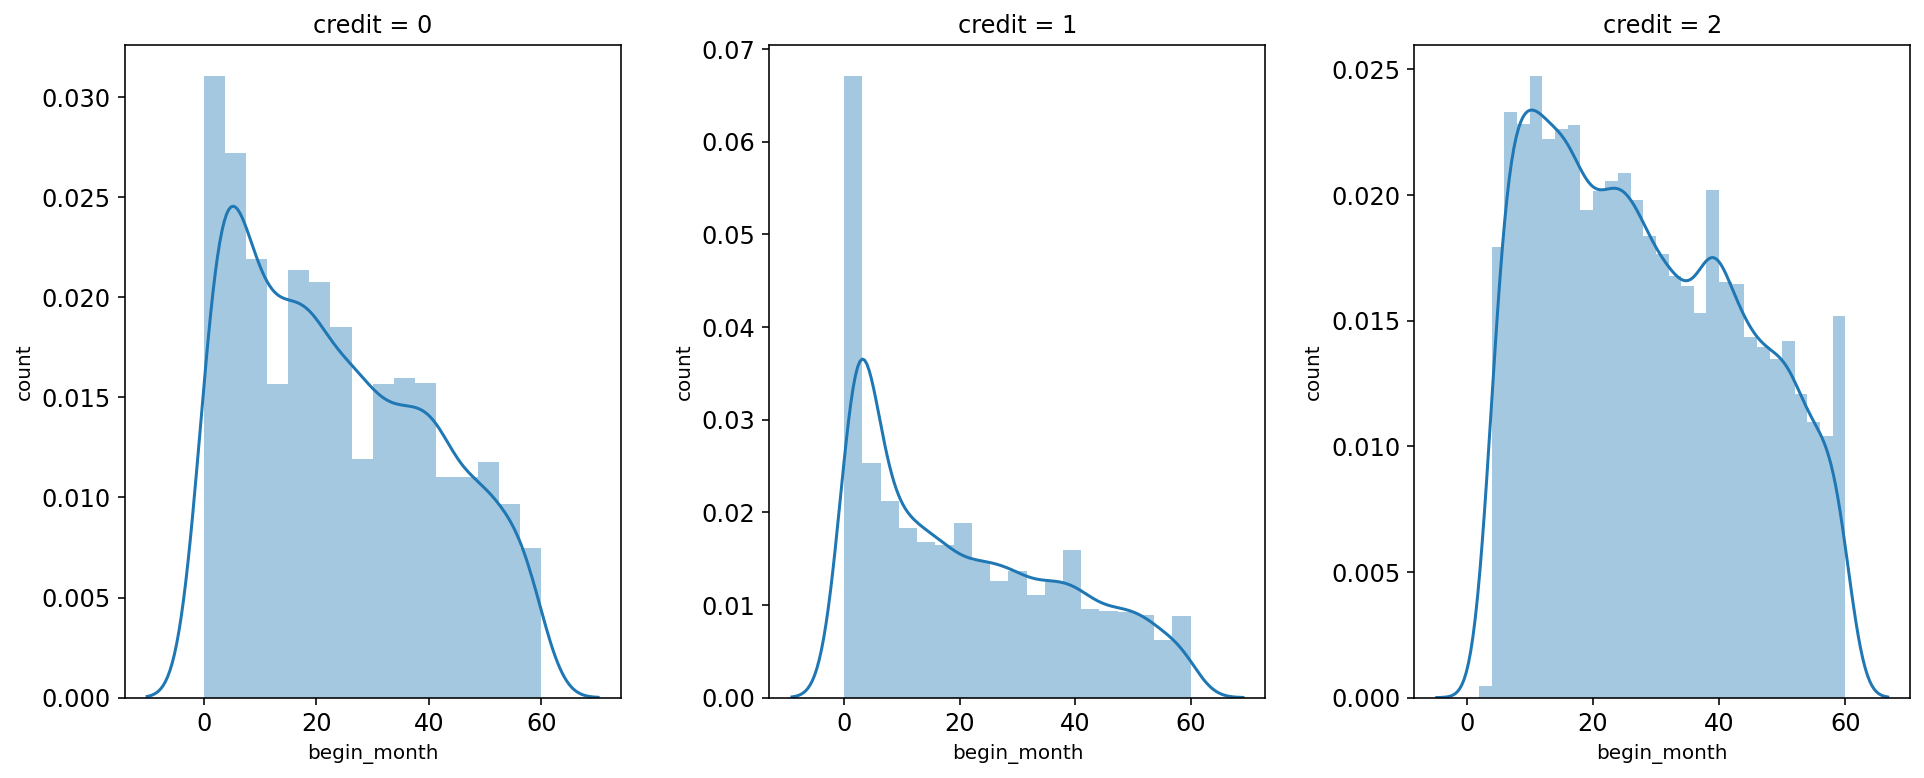

In [ ]:
num_plot("begin_month")

탐색 결과 begin_month=0인 케이스가 credit=1에 다수 분포 되어있음을 확인할 수 있습니다.


###**업무 시작일별 신용등급(DAYS_EMPLOYED)**
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미   
양수인 무직은 모두 0으로 처리하고 나머지 값은 /(-365)하여 업무 연차는 나타내는 데이터 "EMPLOYED" 생성

In [ ]:
data[['DAYS_EMPLOYED']].describe()

,DAYS_EMPLOYED
count,26457.000000
mean,59068.750728
std,137475.427503
min,-15713.000000
25%,-3153.000000
50%,-1539.000000
75%,-407.000000
max,365243.000000


양수는 무직이므로 0으로 처리하고, 음수는 연도별 처리.

In [ ]:
data['EMPLOYED'] =data['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)
data['EMPLOYED'] =abs(data['EMPLOYED'])//365
data['EMPLOYED'].describe()

count    26457.000000
mean         5.609480
std          6.426562
min          0.000000
25%          1.000000
50%          4.000000
75%          8.000000
max         43.000000
Name: EMPLOYED, dtype: float64

In [ ]:
train['EMPLOYED'] =train['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)
train['EMPLOYED'] =abs(train['EMPLOYED'])//365
train_0 = train[train['credit']==0.0]
train_1 = train[train['credit']==1.0]
train_2 = train[train['credit']==2.0]

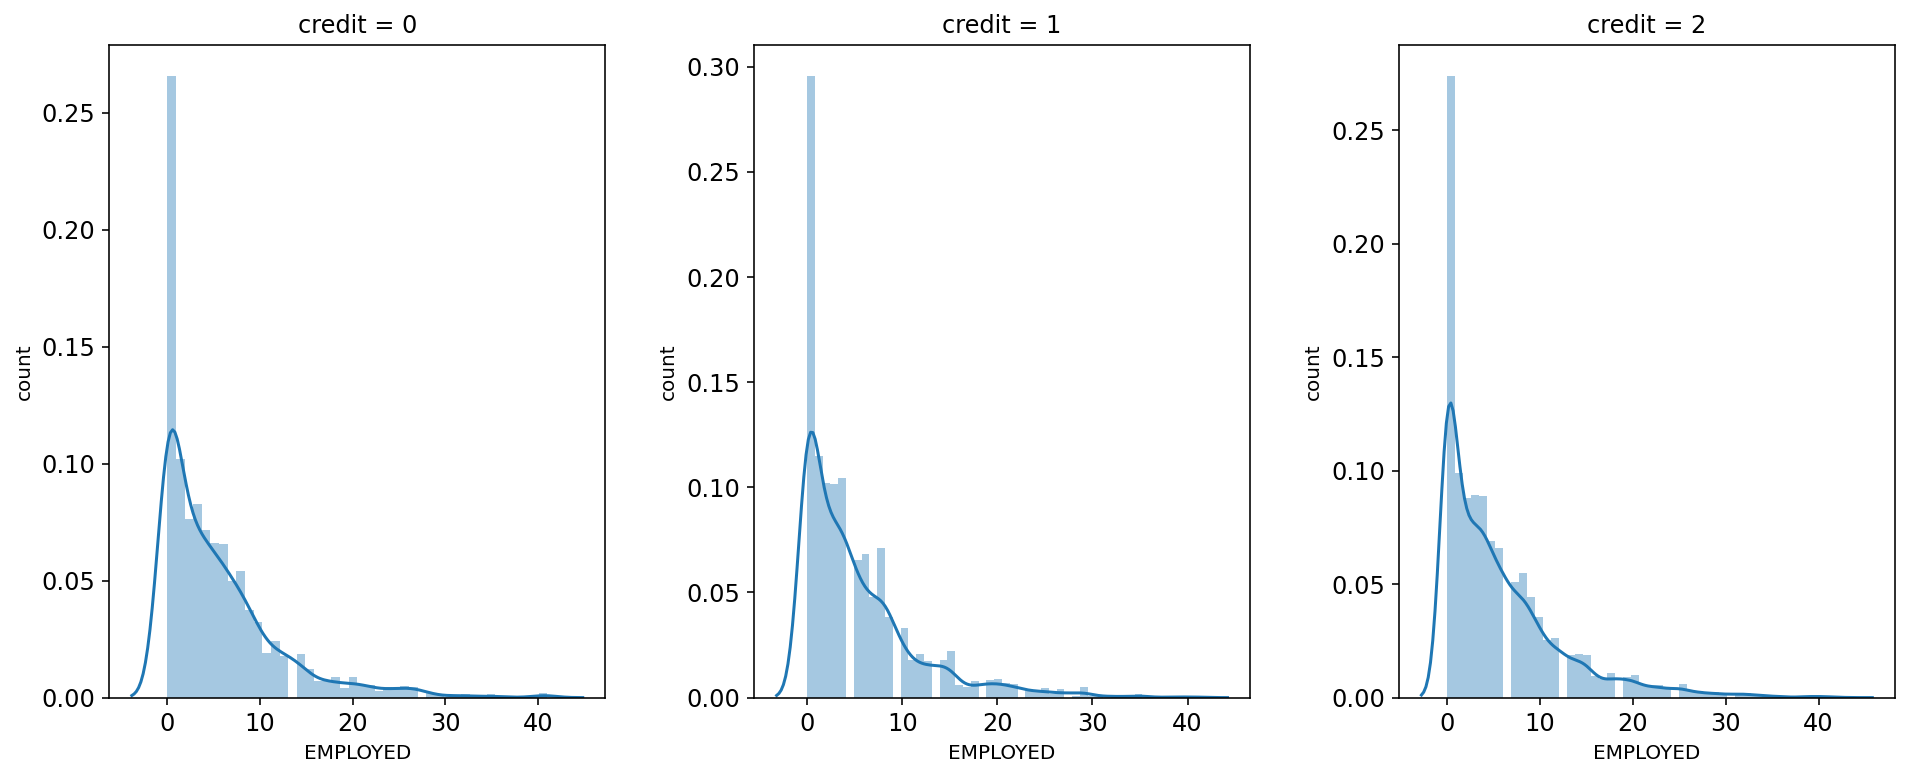

In [ ]:
num_plot("EMPLOYED")

대체로 직업이 없는 사람들이 많다.

###**나이 별 신용등급(DAYS_BIRTH)**
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미   
-365 로 나눠서 나이값 'age' 생성

In [ ]:
data[['DAYS_BIRTH']].describe()

,DAYS_BIRTH
count,26457.000000
mean,-15958.053899
std,4201.589022
min,-25152.000000
25%,-19431.000000
50%,-15547.000000
75%,-12446.000000
max,-7705.000000


In [ ]:
data['age'] =abs(data['DAYS_BIRTH'])//365


In [ ]:
train['age'] =abs(train['DAYS_BIRTH'])//365
train_0 = train[train['credit']==0.0]
train_1 = train[train['credit']==1.0]
train_2 = train[train['credit']==2.0]

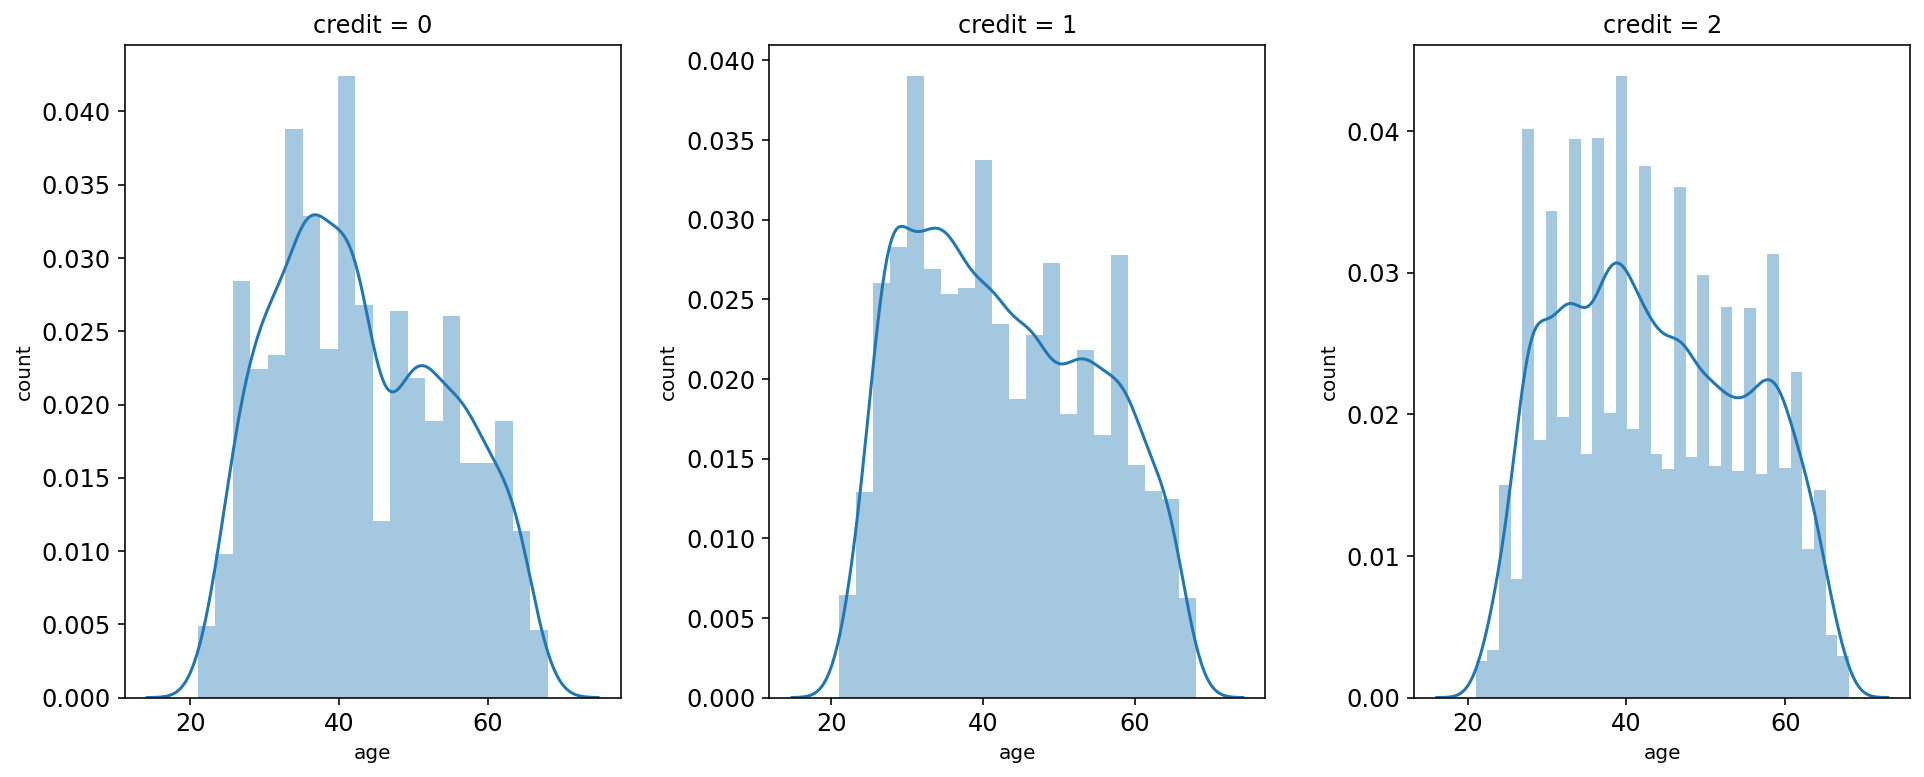

In [ ]:
num_plot("age")

분석 결과 데이터들 사이에 큰 상관관계는 없다고 판단하였습니다.

###**신용등급 별 직업유형 분포(occyp_type)**

In [ ]:
train_0 = train[train['credit']==0.0]
train_1 = train[train['credit']==1.0]
train_2 = train[train['credit']==2.0]

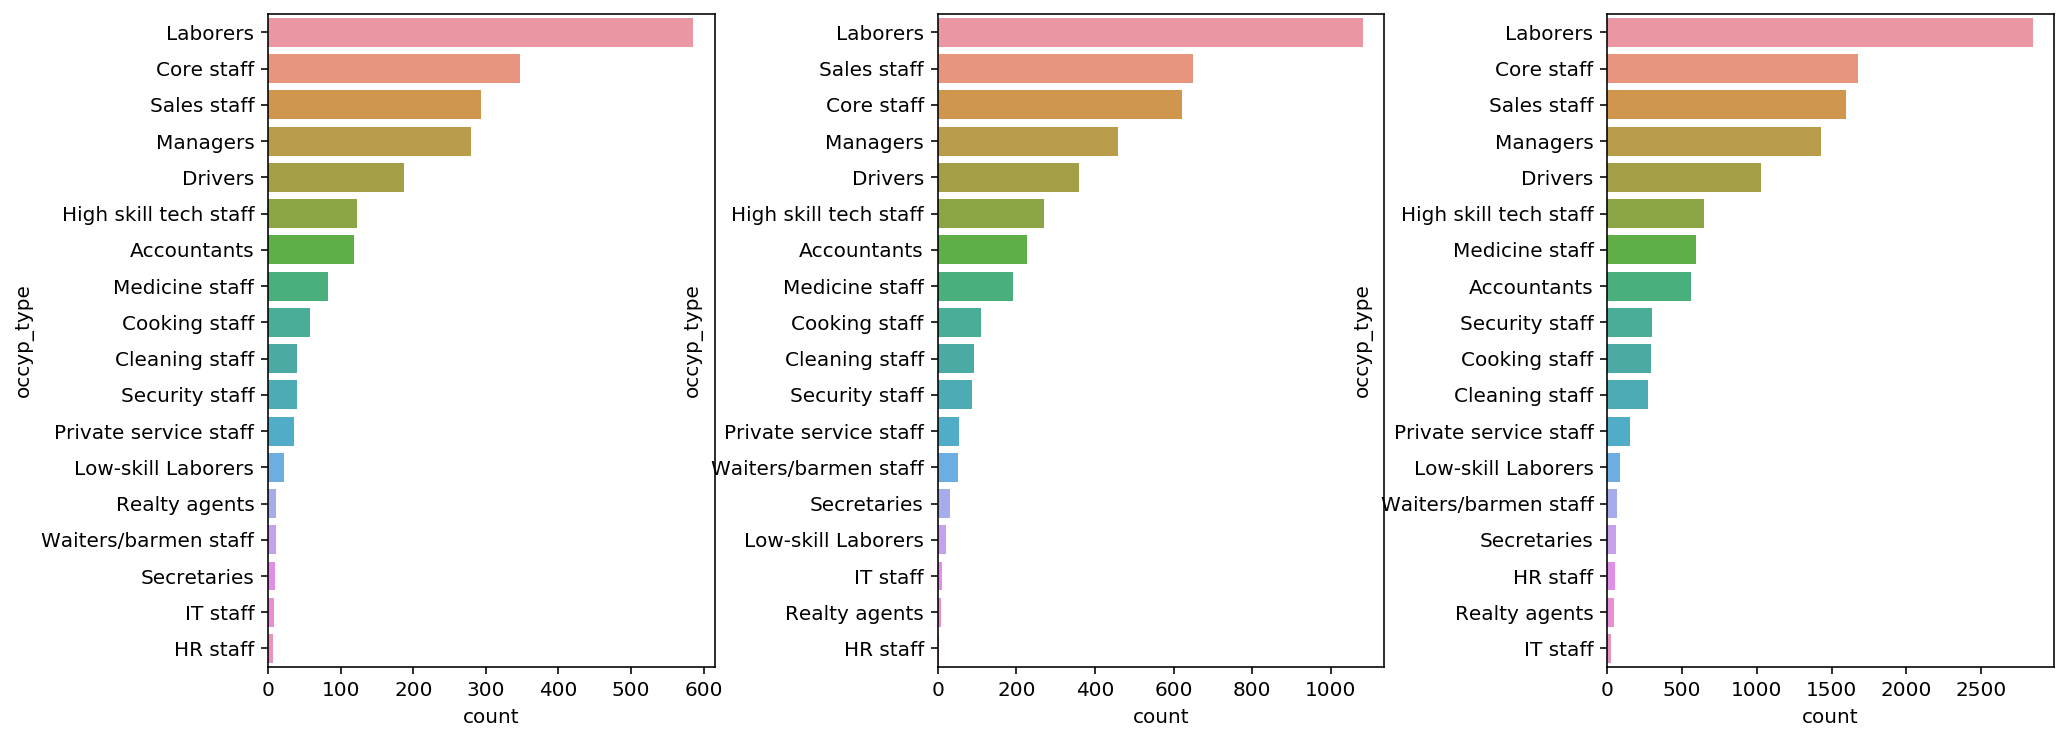

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(16, 6))
sns.countplot(y = 'occyp_type', data = train_0, order = train_0['occyp_type'].value_counts().index, ax=ax[0])
sns.countplot(y = 'occyp_type', data = train_1, order = train_1['occyp_type'].value_counts().index, ax=ax[1])
sns.countplot(y = 'occyp_type', data = train_2, order = train_2['occyp_type'].value_counts().index, ax=ax[2])
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show()

마지막으로 직업유형 데이터를 분석하겠습니다.
직업유형 데이터는 18개의 라벨로 구분되어 있으며, 전체 데이터 중 결측값을 갖고 있는 유일한 특성입니다.
30%의 데이터가 결측값을 갖고 있으므로 삭제하지 않고 SimpleImputer를 통해 결측치를 채워주었습니다.
데이터 분석 결과 각 credit 등급 별로 미세한 직업유형 분포의 차이가 있음을 확인할 수 있었습니다.

#feature engineering

In [ ]:
def engineering(data) :

  data['gender'] = data['gender'].replace(['F','M'],[0,1])
  data['car'] = data['car'].replace(['N','Y'],[0,1])
  data['reality'] = data['reality'].replace(['N','Y'],[0,1])

  data=data.drop('FLAG_MOBIL',axis=1)
  data=data.drop('index',axis=1)

  #자녀 수 3이상 합치기
  data.loc[data['child_num'] > 2, 'child_num'] = 2

  #가족 인원 5이상 합치기
  data.loc[data['family_size'] > 5, 'family_size'] = 5

  #begin_month 현재 음수이므로 양수로 변경
  data['begin_month'] = data['begin_month']*(-1)

  #DAYS_EMPLOYED:업무 시작일
  #데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미
  #양수인 무직은 모두 0으로 처리하고 나머지 값은 /(-365)하여 업무 연차는 나타내는 데이터 "EMPLOYED" 생성
  data['EMPLOYED'] =data['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)
  data['EMPLOYED'] =abs(data['EMPLOYED'])//365

  #DAYS_BIRTH '-365' 로 나눠서 나이값 'age' 생성
  data['age'] =abs(data['DAYS_BIRTH'])//365

  data=data.drop('DAYS_EMPLOYED',axis=1)
  data=data.drop('DAYS_BIRTH',axis=1)


  return data

In [ ]:
train = pd.read_csv("/content/data/train.csv")
train = engineering(train)

In [ ]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,occyp_type,family_size,begin_month,credit,EMPLOYED,age
0,0,0,0,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,0,0,0,NaN,2.0,6.0,1.0,12,38
1,0,0,1,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0,0,1,Laborers,3.0,5.0,1.0,4,31
2,1,1,1,0,450000.0,Working,Higher education,Married,House / apartment,0,1,0,Managers,2.0,22.0,2.0,12,52
3,0,0,1,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,0,1,0,Sales staff,2.0,37.0,0.0,5,41
4,0,1,1,0,157500.0,State servant,Higher education,Married,House / apartment,0,0,0,Managers,2.0,26.0,2.0,5,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0,0,0,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,0,0,0,Core staff,4.0,2.0,1.0,5,33
26453,0,0,1,1,180000.0,Working,Higher education,Separated,House / apartment,0,0,0,NaN,2.0,47.0,2.0,6,41
26454,0,1,0,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,0,0,0,Core staff,2.0,25.0,2.0,5,27
26455,1,0,1,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,0,0,0,Laborers,1.0,59.0,2.0,0,27


In [ ]:
target='credit'
features = train.drop(columns = target).columns

In [ ]:
from sklearn.model_selection import train_test_split

# train / val split
train, test = train_test_split(train, test_size = 0.15, random_state = 34, stratify = train[target])
train, val = train_test_split(train, test_size = 0.2, random_state = 34, stratify = train[target])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((17990, 17), (17990,), (4498, 17), (4498,), (3969, 17), (3969,))

In [ ]:
# baseline model
baseline = train[target].value_counts(normalize = True)
baseline

2.0    0.641301
1.0    0.236909
0.0    0.121790
Name: credit, dtype: float64

imbalanced data이다.   
imbalanced data에서는 Accruacy보다 F1-Score로 성능 측정을 하는 것이 더 효과적이다.   
F1-Score은 recall(실제 값들 중 제대로 예측한 확률)과 precision(예측한 것들 중 실제로 True인 확률)의 조화평균이다.   
뭔가 큰 값이 있다면 패널티를 주어서 작은 값 위주로 평균을 구하게 된다. 따라서 imbalanced data에 효과적이다.   

#Model Fit
다중분류모델임에 유의하자

## RandomForest Classifier

####1)RandomForest Classifier

In [ ]:
# RandomForest Classifier

pipe_rf = make_pipeline(
    TargetEncoder(),
    SimpleImputer(),
    RandomForestClassifier(max_depth = 10,
                           n_estimators = 100,
                           class_weight = 'balanced',
                           criterion = 'entropy',
                           oob_score = True,
                           random_state = 34,
                           n_jobs = -1)
)


pipe_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('targetencoder',
                 TargetEncoder(cols=['income_type', 'edu_type', 'family_type',
                                     'house_type', 'occyp_type'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=1,
                               return_df=True, smoothing=1.0, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='entropy', max_depth=10,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decr



*   average를 macro로 두면 각 열에 대한 precision 값을 모두 더한 다음 열의 갯수로 나눈 것입니다.
*   average를 micro로 두면 전체 평균으로 모든 열에서 맞은 것 즉, 대각선 성분의 총 합을 총 갯수로 나눈 것입니다.
*   average를 None으로 두었을 때 구한 각 열의 Precision들을 산술 평균한 값이 macro가 됩니다.



In [ ]:
y_train_pred = pipe_rf.predict(X_train)
y_val_pred = pipe_rf.predict(X_val)
print('훈련 정확도(f1_score):', f1_score(y_train, y_train_pred,average= 'micro'))
print('검증 정확도(f1_score):', f1_score(y_val, y_val_pred,average='micro'))

훈련 정확도(f1_score): 0.7645358532518065
검증 정확도(f1_score): 0.6800800355713651


In [ ]:
y_val_pred_proba = pipe_rf.predict_proba(X_val)

print(classification_report(y_val, y_val_pred))
print('auc score :', roc_auc_score(y_val, y_val_pred_proba,average='macro',multi_class='ovo'))

              precision    recall  f1-score   support

         0.0       0.34      0.19      0.24       548
         1.0       0.62      0.34      0.44      1065
         2.0       0.72      0.90      0.80      2885

    accuracy                           0.68      4498
   macro avg       0.56      0.48      0.49      4498
weighted avg       0.65      0.68      0.65      4498

auc score : 0.677726520669387


####2)RandomForest Classifie+RandomSearchCV

In [ ]:
# RandomizedSearchCV

dist = {
    'simpleimputer__strategy' : ['mean', 'median', 'most_frequent'],
    'randomforestclassifier__n_estimators' : range(1, 1000, 50),
    'randomforestclassifier__max_depth' : randint(5, 20),
    'randomforestclassifier__max_features' : uniform(0, 1)
}

clf = RandomizedSearchCV(pipe_rf, 
                            param_distributions = dist,
                            n_iter = 50,
                            cv = 3,
                            verbose = 1,
                            n_jobs = -1, 
                            random_state = 34
)


clf.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 24.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('targetencoder',
                                              TargetEncoder(cols=['income_type',
                                                                  'edu_type',
                                                                  'family_type',
                                                                  'house_type',
                                                                  'occyp_type'],
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            min_samples_leaf=1,
                                                            return_df=True,
                                     

In [ ]:
clf.best_params_

{'randomforestclassifier__max_depth': 19,
 'randomforestclassifier__max_features': 0.19507498193818096,
 'randomforestclassifier__n_estimators': 801,
 'simpleimputer__strategy': 'most_frequent'}

In [ ]:
pipe_rf=clf.best_estimator_
y_train_pred = pipe_rf.predict(X_train)
y_val_pred = pipe_rf.predict(X_val)
print('훈련 정확도(f1_score):', f1_score(y_train, y_train_pred,average= 'micro'))
print('검증 정확도(f1_score):', f1_score(y_val, y_val_pred,average='micro'))

훈련 정확도(f1_score): 0.9555308504724848
검증 정확도(f1_score): 0.7072032014228548


In [ ]:
y_val_pred_proba = pipe_rf.predict_proba(X_val)

print(classification_report(y_val, y_val_pred))
print('auc score :', roc_auc_score(y_val, y_val_pred_proba,average='macro',multi_class='ovo'))

              precision    recall  f1-score   support

         0.0       0.41      0.25      0.31       548
         1.0       0.63      0.46      0.54      1065
         2.0       0.75      0.88      0.81      2885

    accuracy                           0.71      4498
   macro avg       0.60      0.53      0.55      4498
weighted avg       0.68      0.71      0.69      4498

auc score : 0.7178171312534087


####3)RandomForest Classifie+GridsearchCV

In [ ]:
# GridsearchCV
from tqdm import tqdm
grid_params = {'targetencoder__smoothing' : [1.0, 3.0, 5.0],
               'simpleimputer__strategy' : ['mean'],
               'randomforestclassifier__max_depth': [15,19,20],
               'randomforestclassifier__max_features' : [0.1, 0.195, 0.3],
               'randomforestclassifier__n_estimators' : [500, 800, 1000]
}


for cv in tqdm(range(3,4)):
    clf = GridSearchCV(pipe_rf,
                        param_grid = grid_params,
                        cv = cv,
                        verbose = 1,
                        n_jobs = -1)

    clf.fit(X_train, y_train)

  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 41.7min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 55.4min finished
100%|██████████| 1/1 [55:41<00:00, 3341.50s/it]


In [ ]:
clf.best_params_

{'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__max_features': 0.3,
 'randomforestclassifier__n_estimators': 500,
 'simpleimputer__strategy': 'mean',
 'targetencoder__smoothing': 1.0}

In [ ]:
pipe_rf=clf.best_estimator_
y_train_pred = pipe_rf.predict(X_train)
y_val_pred = pipe_rf.predict(X_val)
print('훈련 정확도(f1_score):', f1_score(y_train, y_train_pred,average= 'micro'))
print('검증 정확도(f1_score):', f1_score(y_val, y_val_pred,average='micro'))

훈련 정확도(f1_score): 0.9652028904947193
검증 정확도(f1_score): 0.7036460649177412


In [ ]:
y_val_pred_proba = pipe_rf.predict_proba(X_val)

print(classification_report(y_val, y_val_pred))
print('auc score :', roc_auc_score(y_val, y_val_pred_proba,average='macro',multi_class='ovo'))

              precision    recall  f1-score   support

         0.0       0.42      0.23      0.29       548
         1.0       0.64      0.44      0.52      1065
         2.0       0.74      0.89      0.81      2885

    accuracy                           0.70      4498
   macro avg       0.60      0.52      0.54      4498
weighted avg       0.68      0.70      0.68      4498

auc score : 0.7117948770944175


##LGBMClassifier

*   Light GBM은 Gradient Boosting 프레워크로 Tree 기반 학습 알고리즘
*   Light GBM은 Tree가 수직적으로 확장되는 반면에 다른 알고리즘은 Tree가 수평적으로 확장
*   즉 Light GBM은 leaf-wise 인 반면 다른 알고리즘은 level-wise
*   동일한 leaf를 확장할 때, leaf-wise 알고리즘은 level-wise 알고리즘보다 더 많은 loss, 손실을 줄일 수 있다.
*   과적합 잘 일어나므로 10000건 이하의 데이터의 경우 사용에 주의하자. 사용하고싶다면 교차검증 꼭 이용하자.

####1)LGBMClassifier Classifier

In [ ]:
from lightgbm import LGBMClassifier


pipe_LGBM = make_pipeline(
        OrdinalEncoder(),
        LGBMClassifier(random_state = 34,
                         n_jobs = -1,
                         n_estimators = 100,
                         max_depth = 10,
                         class_weight = 'balanced')
)

pipe_LGBM.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['income_type', 'edu_type', 'family_type',
                                      'house_type', 'occyp_type'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'income_type',
                                          'data_type': dtype('O'),
                                          'mapping': Working                 1
State servant           2
Commercial associate    3
Pensioner               4
Student                 5
NaN                    -2
dtype: int64},
                                         {'col': 'ed...
                 LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=10,
                            

In [ ]:
y_train_pred = pipe_LGBM.predict(X_train)
y_val_pred = pipe_LGBM.predict(X_val)
print('훈련 정확도(f1_score):', f1_score(y_train, y_train_pred,average= 'micro'))
print('검증 정확도(f1_score):', f1_score(y_val, y_val_pred,average='micro'))

훈련 정확도(f1_score): 0.711839911061701
검증 정확도(f1_score): 0.5984882169853268


In [ ]:
y_val_pred = pipe_LGBM.predict(X_val)
y_val_pred_proba = pipe_LGBM.predict_proba(X_val)

print(classification_report(y_val, y_val_pred))
print('auc score :', roc_auc_score(y_val, y_val_pred_proba,average='macro',multi_class='ovo'))

              precision    recall  f1-score   support

         0.0       0.22      0.34      0.27       548
         1.0       0.50      0.42      0.46      1065
         2.0       0.74      0.71      0.73      2885

    accuracy                           0.60      4498
   macro avg       0.49      0.49      0.48      4498
weighted avg       0.62      0.60      0.61      4498

auc score : 0.6785577312033894


####2)LGBMClassifier Classifier+RandomSearchCV

In [ ]:
# RandomizedSearchCV
pipe_LGBM = make_pipeline(
        TargetEncoder(),
        LGBMClassifier(random_state = 34,
                         n_jobs = -1,
                         class_weight = 'balanced')
)
dist = {
    'lgbmclassifier__n_estimators' : range(1, 1000, 50),
    'lgbmclassifier__max_depth' :randint(5, 20),
    'lgbmclassifier__max_features' : uniform(0, 1),
}

clf= RandomizedSearchCV(pipe_LGBM, 
                            param_distributions = dist,
                            n_iter = 20,
                            cv = 5,
                            verbose = 1,
                            n_jobs = -1, 
                            random_state = 34
)

clf.get_params().keys()
clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('targetencoder',
                                              TargetEncoder(cols=None,
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            min_samples_leaf=1,
                                                            return_df=True,
                                                            smoothing=1.0,
                                                            verbose=0)),
                                             ('lgbmclassifier',
                                              LGBMClassifier(boosting_type='gbdt',
                                                             class_weigh

In [ ]:
clf.best_params_

{'lgbmclassifier__max_depth': 13,
 'lgbmclassifier__max_features': 0.836476440894443,
 'lgbmclassifier__n_estimators': 651}

In [ ]:
pipe_LGBM=clf.best_estimator_
y_train_pred = pipe_LGBM.predict(X_train)
y_val_pred = pipe_LGBM.predict(X_val)
print('훈련 정확도(f1_score):', f1_score(y_train, y_train_pred,average= 'micro'))
print('검증 정확도(f1_score):', f1_score(y_val, y_val_pred,average='micro'))

훈련 정확도(f1_score): 0.8859366314619233
검증 정확도(f1_score): 0.6436193863939529


In [ ]:
y_val_pred = pipe_LGBM.predict(X_val)
y_val_pred_proba = pipe_LGBM.predict_proba(X_val)

print(classification_report(y_val, y_val_pred))
print('auc score :', roc_auc_score(y_val, y_val_pred_proba,average='macro',multi_class='ovo'))

              precision    recall  f1-score   support

         0.0       0.30      0.33      0.32       548
         1.0       0.52      0.48      0.50      1065
         2.0       0.76      0.76      0.76      2885

    accuracy                           0.64      4498
   macro avg       0.52      0.53      0.52      4498
weighted avg       0.65      0.64      0.64      4498

auc score : 0.6952708107138476


####3)LGBMClassifier Classifier+GridsearchCV

In [ ]:
# GridsearchCV
from tqdm import tqdm
pipe_LGBM = make_pipeline(
        TargetEncoder(),
        SimpleImputer(),
        LGBMClassifier(random_state = 34,
                         n_jobs = -1,
                         class_weight = 'balanced')
)
grid_params = {'targetencoder__smoothing' : [1.0, 3.0, 5.0],
               'simpleimputer__strategy' : ['mean'],
               'lgbmclassifier__max_depth': [10,13,16],
               'lgbmclassifier__max_features' : [0.8, 0.84, 0.95],
               'lgbmclassifier__n_estimators' : [500, 651, 1000]
}


for cv in tqdm(range(3,4)):
  clf = GridSearchCV(pipe_LGBM,
                        param_grid = grid_params,
                        cv = cv,
                        verbose = 1,
                        n_jobs = -1)

  clf.fit(X_train, y_train)

  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 17.7min finished
100%|██████████| 1/1 [17:49<00:00, 1069.74s/it]


In [ ]:
clf.best_params_

{'lgbmclassifier__max_depth': 16,
 'lgbmclassifier__max_features': 0.8,
 'lgbmclassifier__n_estimators': 1000,
 'simpleimputer__strategy': 'mean',
 'targetencoder__smoothing': 1.0}

In [ ]:
pipe_rf=clf.best_estimator_
y_train_pred = pipe_rf.predict(X_train)
y_val_pred = pipe_rf.predict(X_val)
print('훈련 정확도(f1_score):', f1_score(y_train, y_train_pred,average= 'micro'))
print('검증 정확도(f1_score):', f1_score(y_val, y_val_pred,average='micro'))

훈련 정확도(f1_score): 0.9175653140633685
검증 정확도(f1_score): 0.6393952867941307


In [ ]:
y_val_pred_proba = pipe_rf.predict_proba(X_val)

print(classification_report(y_val, y_val_pred))
print('auc score :', roc_auc_score(y_val, y_val_pred_proba,average='macro',multi_class='ovo'))

              precision    recall  f1-score   support

         0.0       0.30      0.31      0.30       548
         1.0       0.51      0.47      0.49      1065
         2.0       0.75      0.76      0.76      2885

    accuracy                           0.64      4498
   macro avg       0.52      0.52      0.52      4498
weighted avg       0.64      0.64      0.64      4498

auc score : 0.6971629733987027


#최종 모델

In [ ]:
{'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__max_features': 0.3,
 'randomforestclassifier__n_estimators': 500,
 'simpleimputer__strategy': 'mean',
 'targetencoder__smoothing': 1.0}

In [ ]:
#pipeline이 shap에서 잘 안먹어서 분리,,
encoder = TargetEncoder(smoothing= 1.0)
X_train_encoded = encoder.fit_transform(X_train, y_train) # 학습데이터
X_val_encoded = encoder.transform(X_val, y_val) # 검증데이터

transformer = SimpleImputer(strategy='mean')
X_train_Imputed= transformer.fit_transform(X_train_encoded )
X_val_Imputed= transformer.fit_transform(X_val_encoded )

model = RandomForestClassifier(max_depth = 20,
                           n_estimators = 500,
                           class_weight = 'balanced',
                           criterion = 'entropy',
                           max_features=0.3,  
                           oob_score = True,
                           random_state = 34,
                           n_jobs = -1)

In [ ]:
model.fit(X_train_Imputed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=20, max_features=0.3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=34, verbose=0,
                       warm_start=False)

In [ ]:
y_train_pred = model.predict(X_train_Imputed)
y_val_pred = model.predict(X_val_Imputed)
print('훈련 정확도(f1_score):', f1_score(y_train, y_train_pred,average= 'micro'))
print('검증 정확도(f1_score):', f1_score(y_val, y_val_pred,average='micro'))

훈련 정확도(f1_score): 0.9652028904947193
검증 정확도(f1_score): 0.7036460649177412


In [ ]:
y_train_pred_proba = model.predict_proba(X_train_Imputed)

print(classification_report(y_train, y_train_pred))
print('auc score :', roc_auc_score(y_train, y_train_pred_proba,average='macro',multi_class='ovo'))

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94      2191
         1.0       0.96      0.94      0.95      4262
         2.0       0.98      0.98      0.98     11537

    accuracy                           0.97     17990
   macro avg       0.95      0.96      0.95     17990
weighted avg       0.97      0.97      0.97     17990

auc score : 0.9963512145739953


In [ ]:
y_val_pred_proba = model.predict_proba(X_val_Imputed)

print(classification_report(y_val, y_val_pred))
print('auc score :', roc_auc_score(y_val, y_val_pred_proba,average='macro',multi_class='ovo'))

              precision    recall  f1-score   support

         0.0       0.42      0.23      0.29       548
         1.0       0.64      0.44      0.52      1065
         2.0       0.74      0.89      0.81      2885

    accuracy                           0.70      4498
   macro avg       0.60      0.52      0.54      4498
weighted avg       0.68      0.70      0.68      4498

auc score : 0.7117948770944175


In [ ]:
X_test_encoded = encoder.transform(X_test, y_test) # 테스트데이터
X_test_Imputed= transformer.fit_transform(X_test_encoded )
y_test_pred = model.predict(X_test_Imputed)
print('검증 정확도(f1_score):', f1_score(y_test, y_test_pred,average='micro'))

검증 정확도(f1_score): 0.6948853615520282


In [ ]:
y_test_pred_proba = model.predict_proba(X_test_Imputed)

print(classification_report(y_test, y_test_pred))
print('auc score :', roc_auc_score(y_test, y_test_pred_proba,average='macro',multi_class='ovo'))

              precision    recall  f1-score   support

         0.0       0.39      0.20      0.27       483
         1.0       0.63      0.43      0.51       940
         2.0       0.73      0.88      0.80      2546

    accuracy                           0.69      3969
   macro avg       0.58      0.51      0.53      3969
weighted avg       0.67      0.69      0.67      3969

auc score : 0.7103356251232552


#시각화 (Visualization)

In [ ]:
X_test['begin_month']

18953    30.0
15783    37.0
14782    30.0
21285    43.0
15317    11.0
         ... 
20067    31.0
9819      3.0
3240     25.0
19041    15.0
1241     17.0
Name: begin_month, Length: 3969, dtype: float64

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


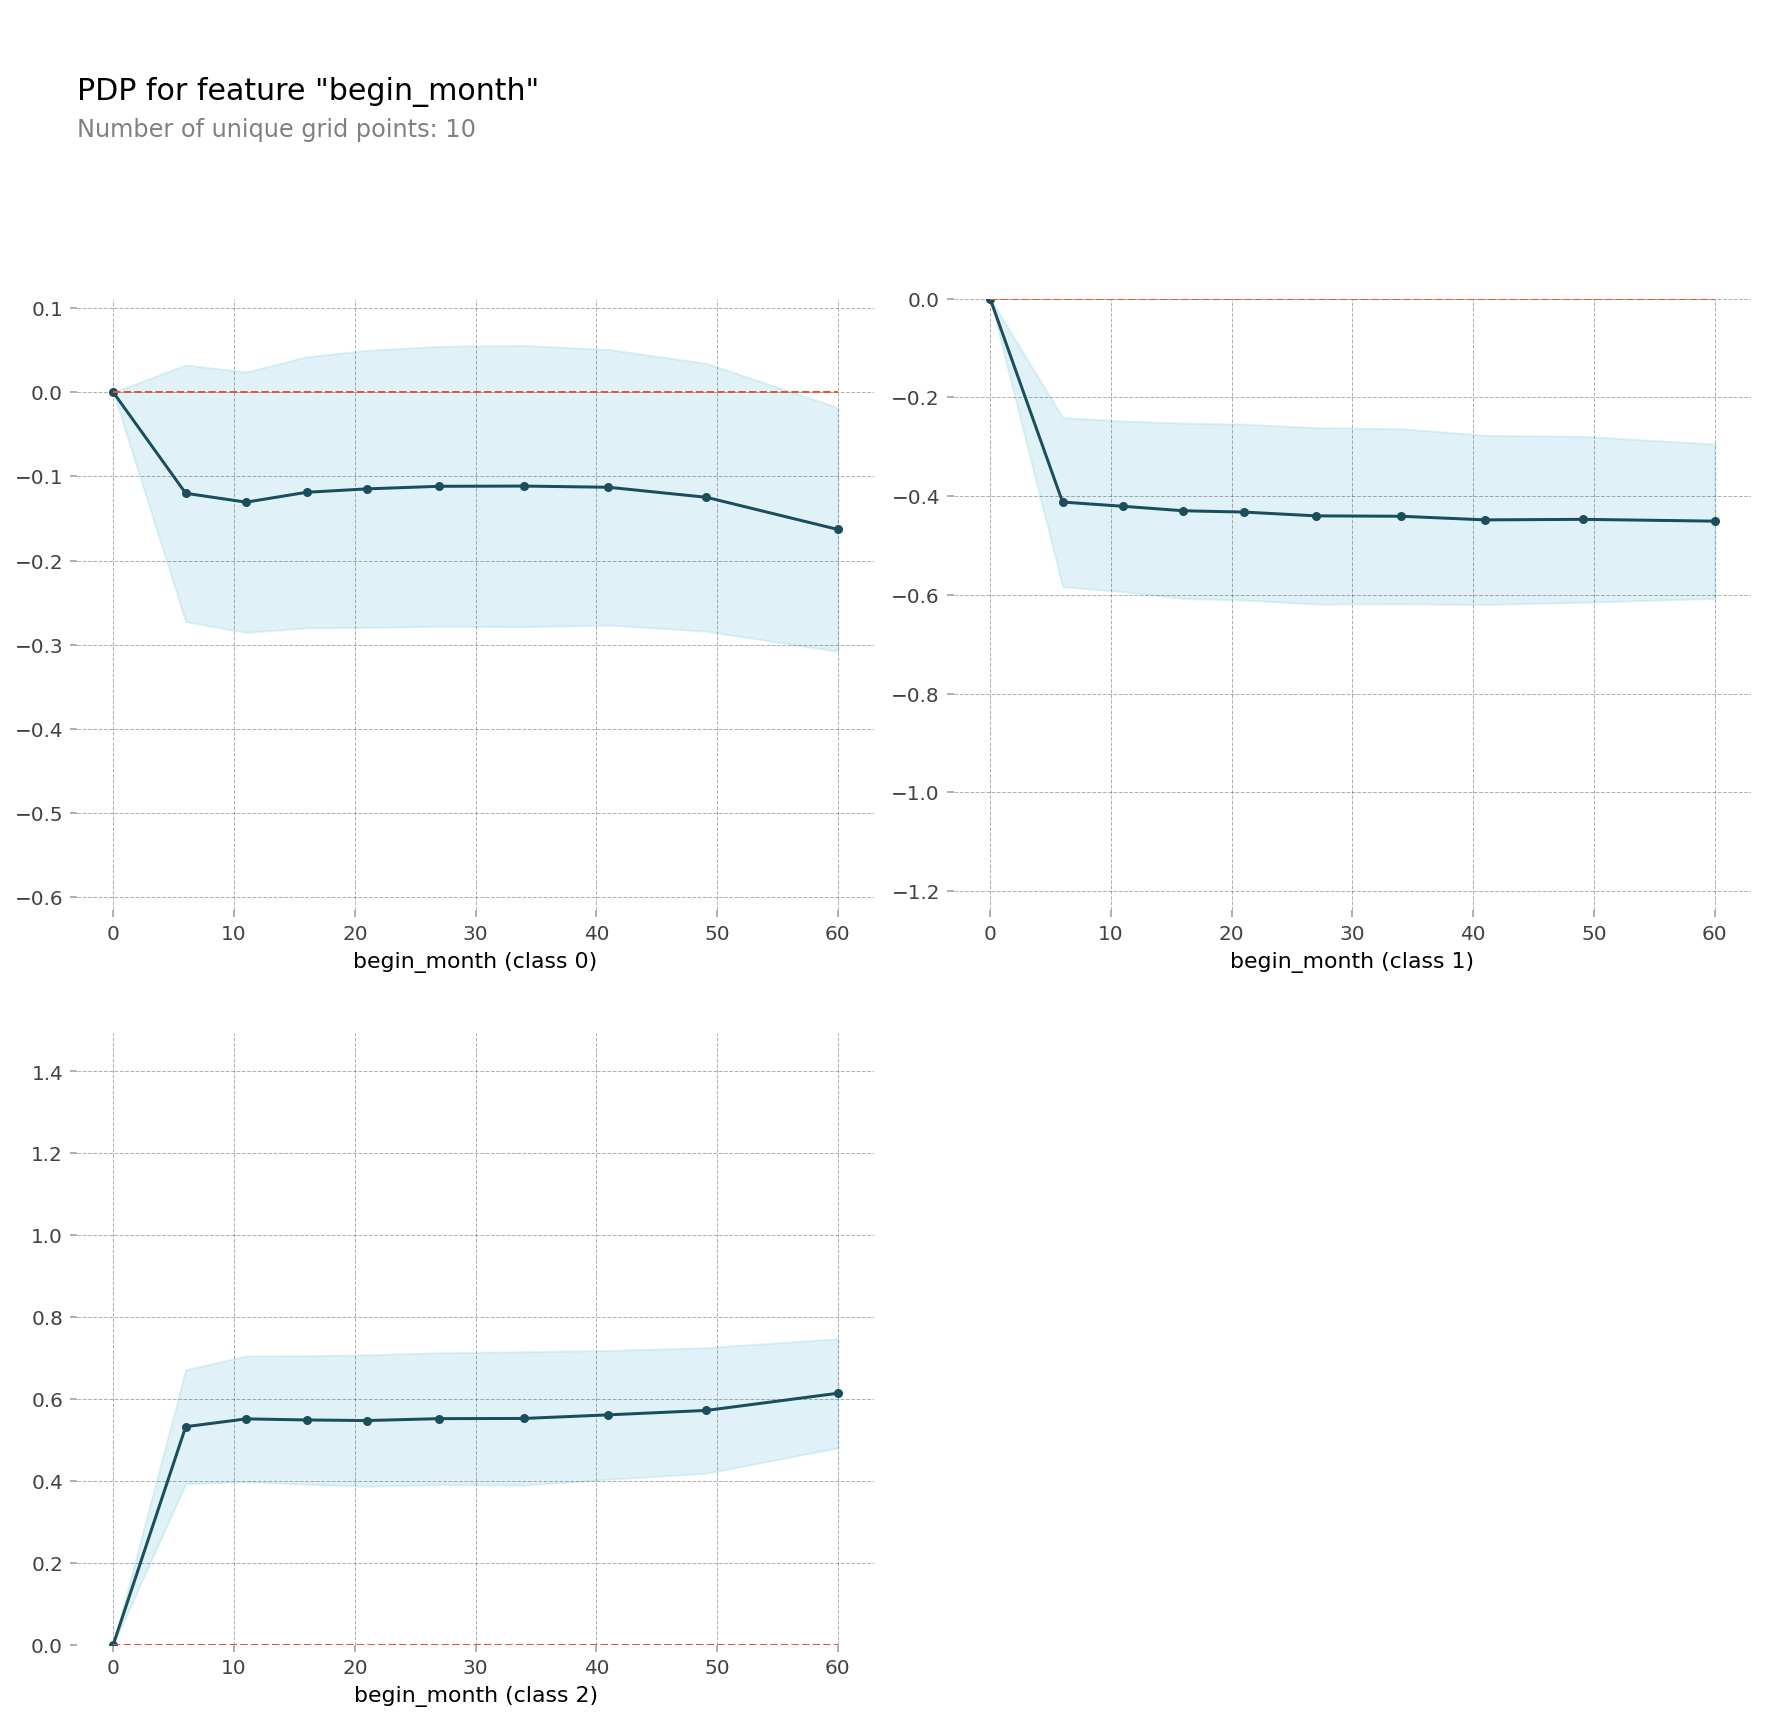

In [ ]:
feature = 'begin_month'
isolated = pdp_isolate(
    model=model, 
    dataset=X_test_encoded.dropna(),  # 결측치가 채워지지 않은 샘플들을 드랍
    model_features=X_test.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);

PDP는 학습된 모델을 해석하는 방법으로, 해당 특성이 target에 어떻게 영향을 주는지 확인하는것을 도와줍니다.    
다음은 모집단의 신용카드 발급 월 데이터에 대한 PDP입니다.   
분석 결과 신용카드를 발급 받은 지 오래 지날수록 신용등급이 떨어질 확률이 높아진다는 것을 확인할 수 있습니다.   

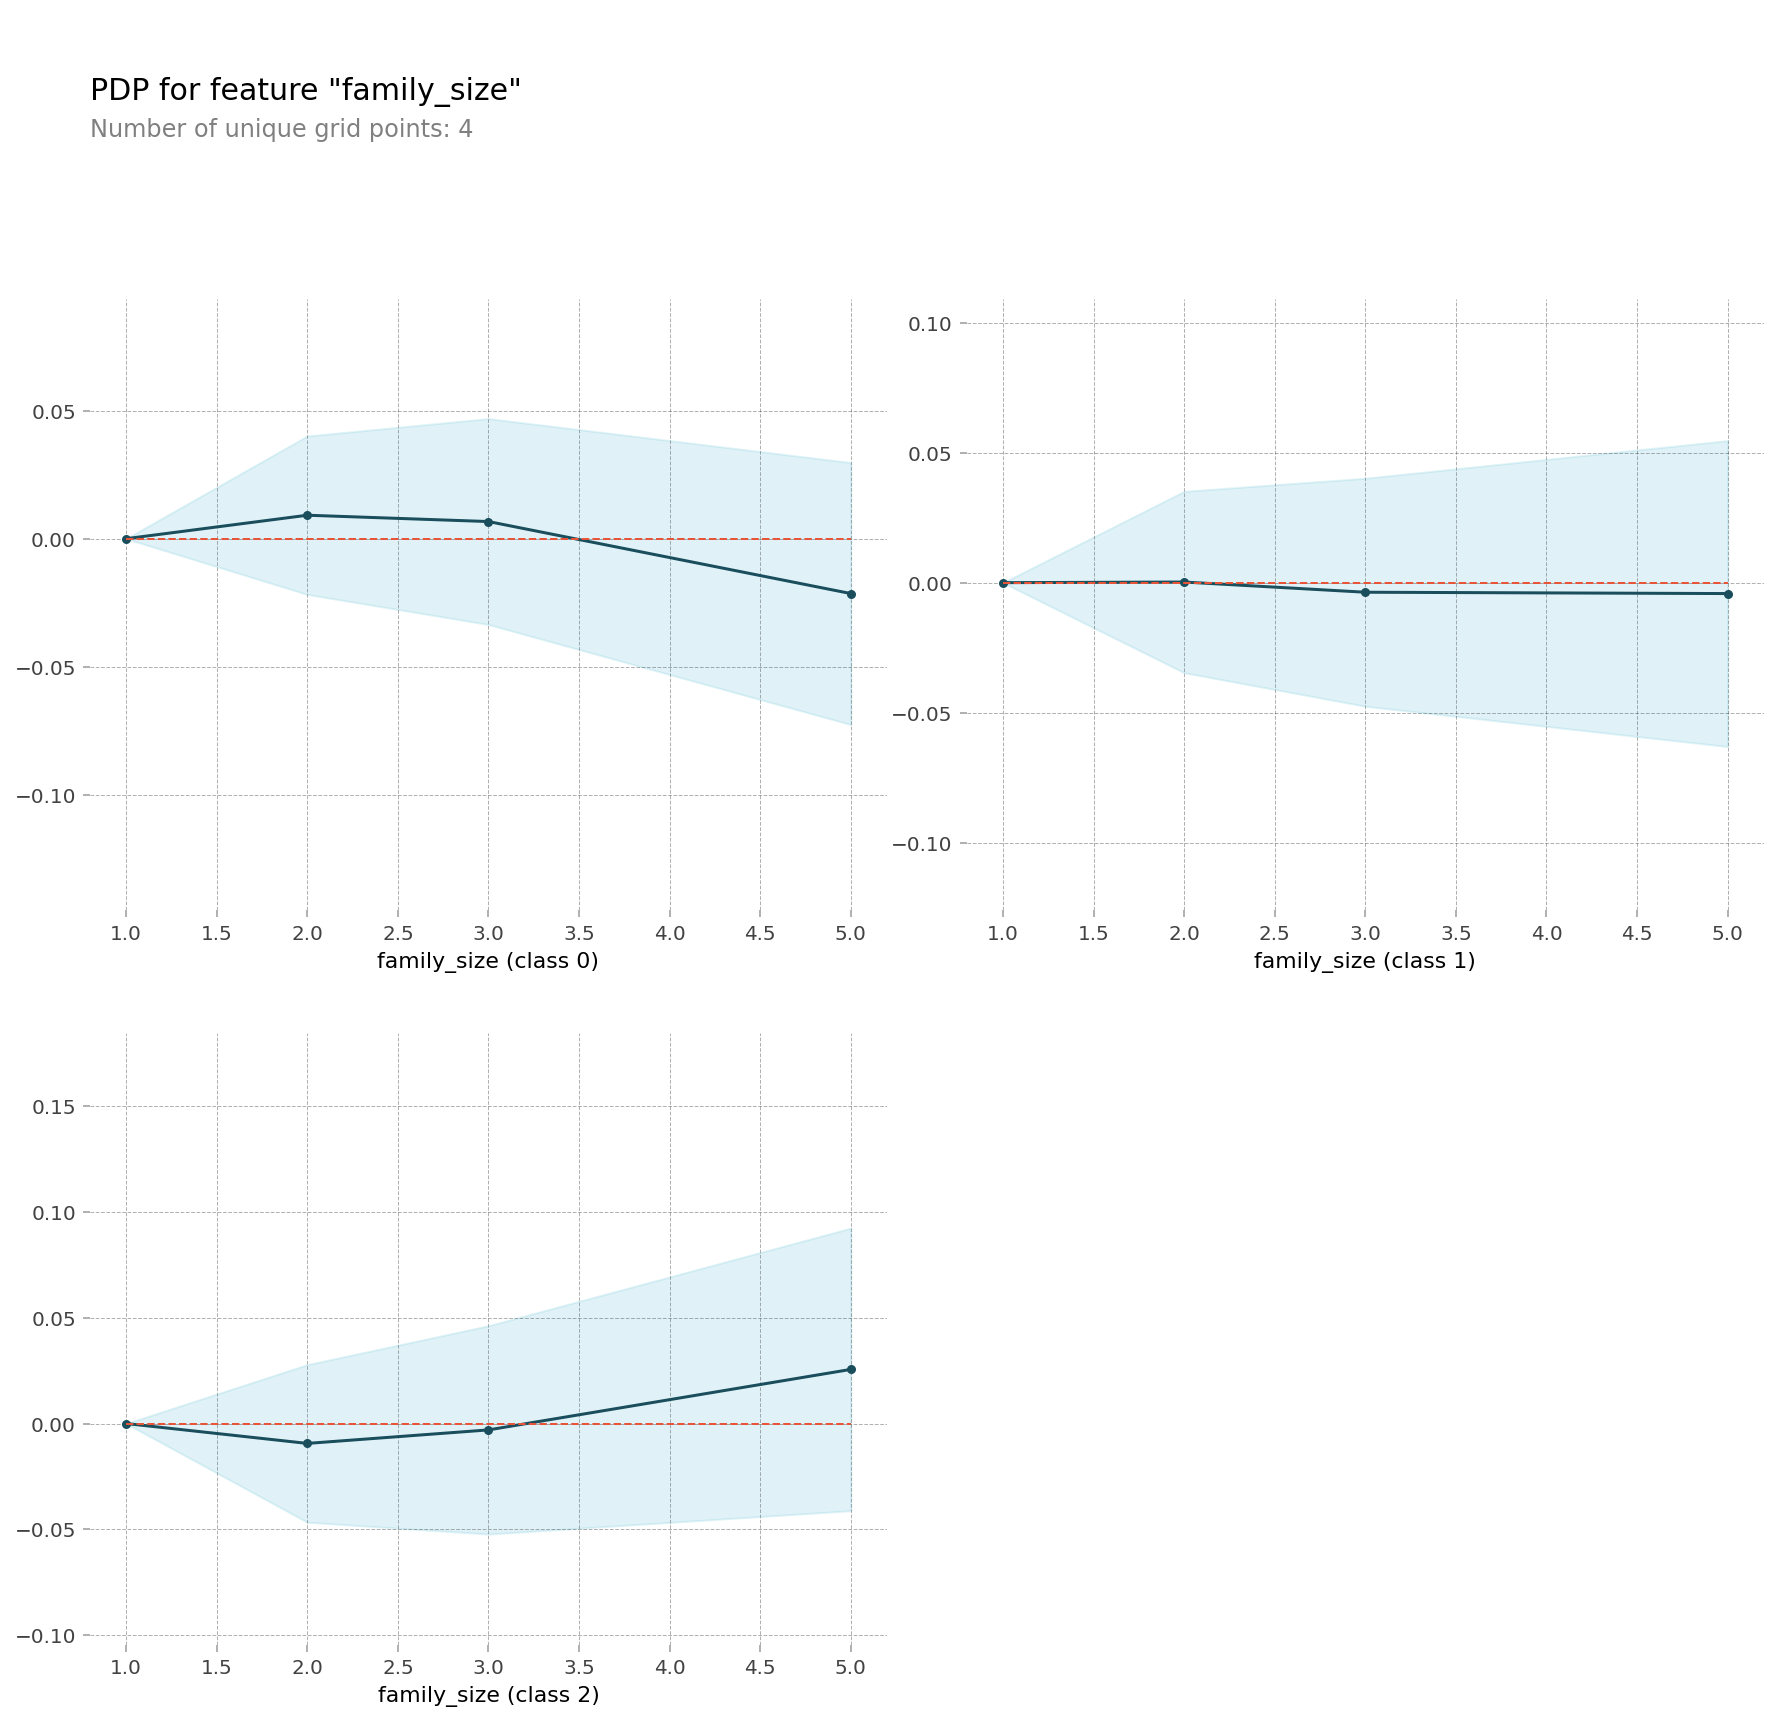

In [ ]:
feature = 'family_size'
isolated = pdp_isolate(
    model=model, 
    dataset=X_test_encoded.dropna(),  # 결측치가 채워지지 않은 샘플들을 드랍
    model_features=X_test.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);

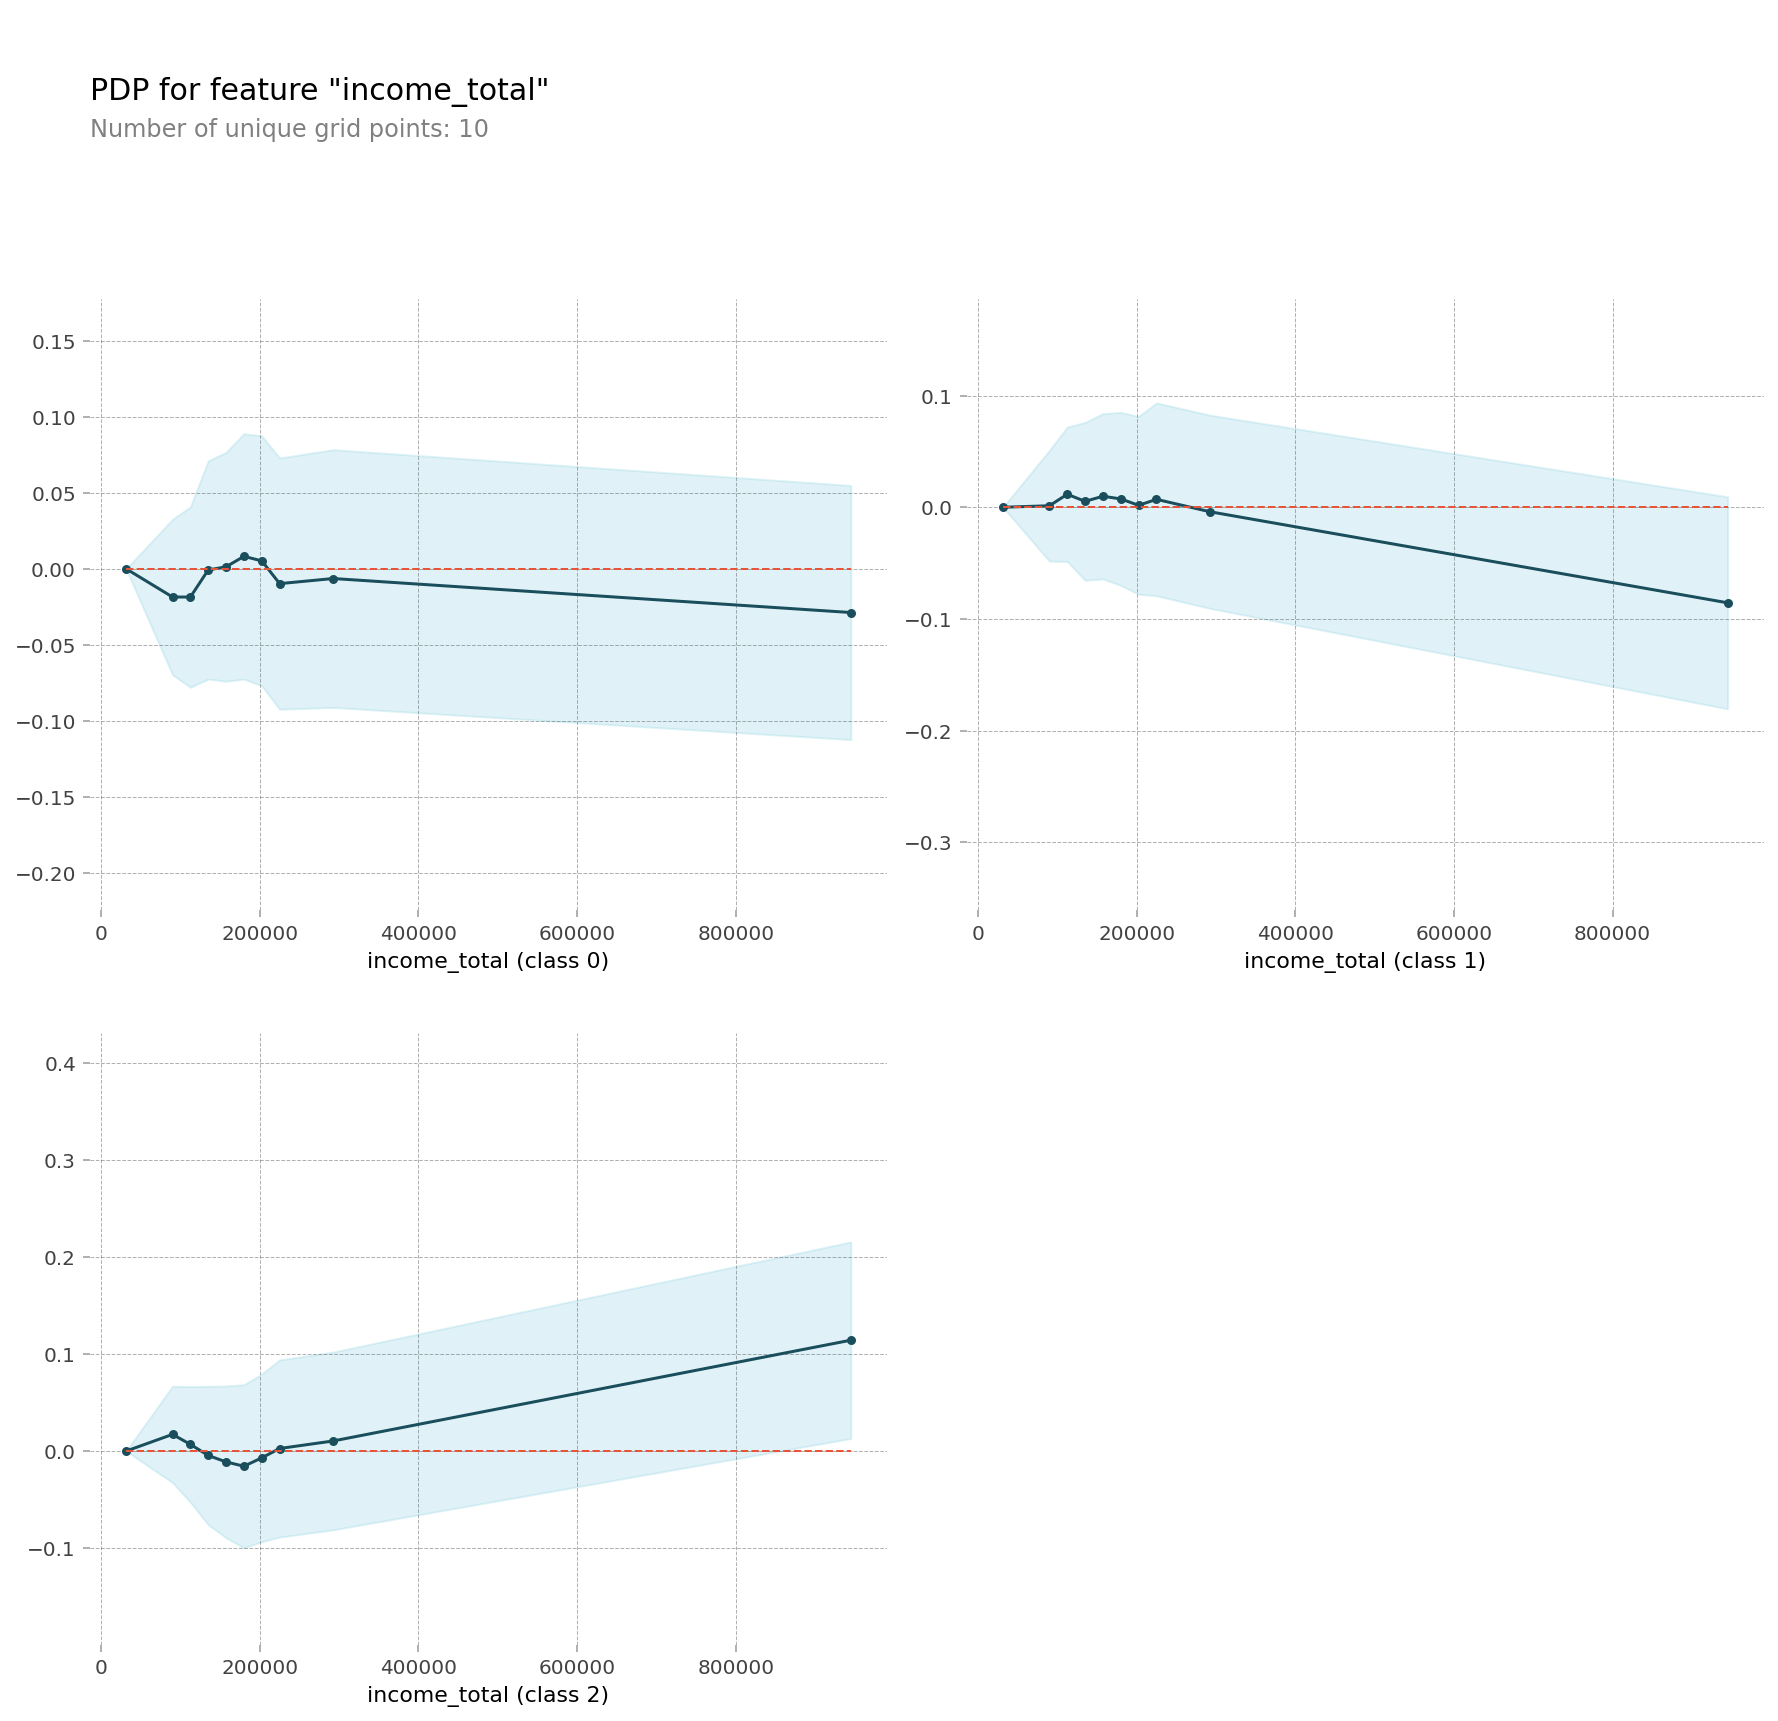

In [ ]:
feature = 'income_total'
isolated = pdp_isolate(
    model=model, 
    dataset=X_test_encoded.dropna(),  # 결측치가 채워지지 않은 샘플들을 드랍
    model_features=X_test.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);

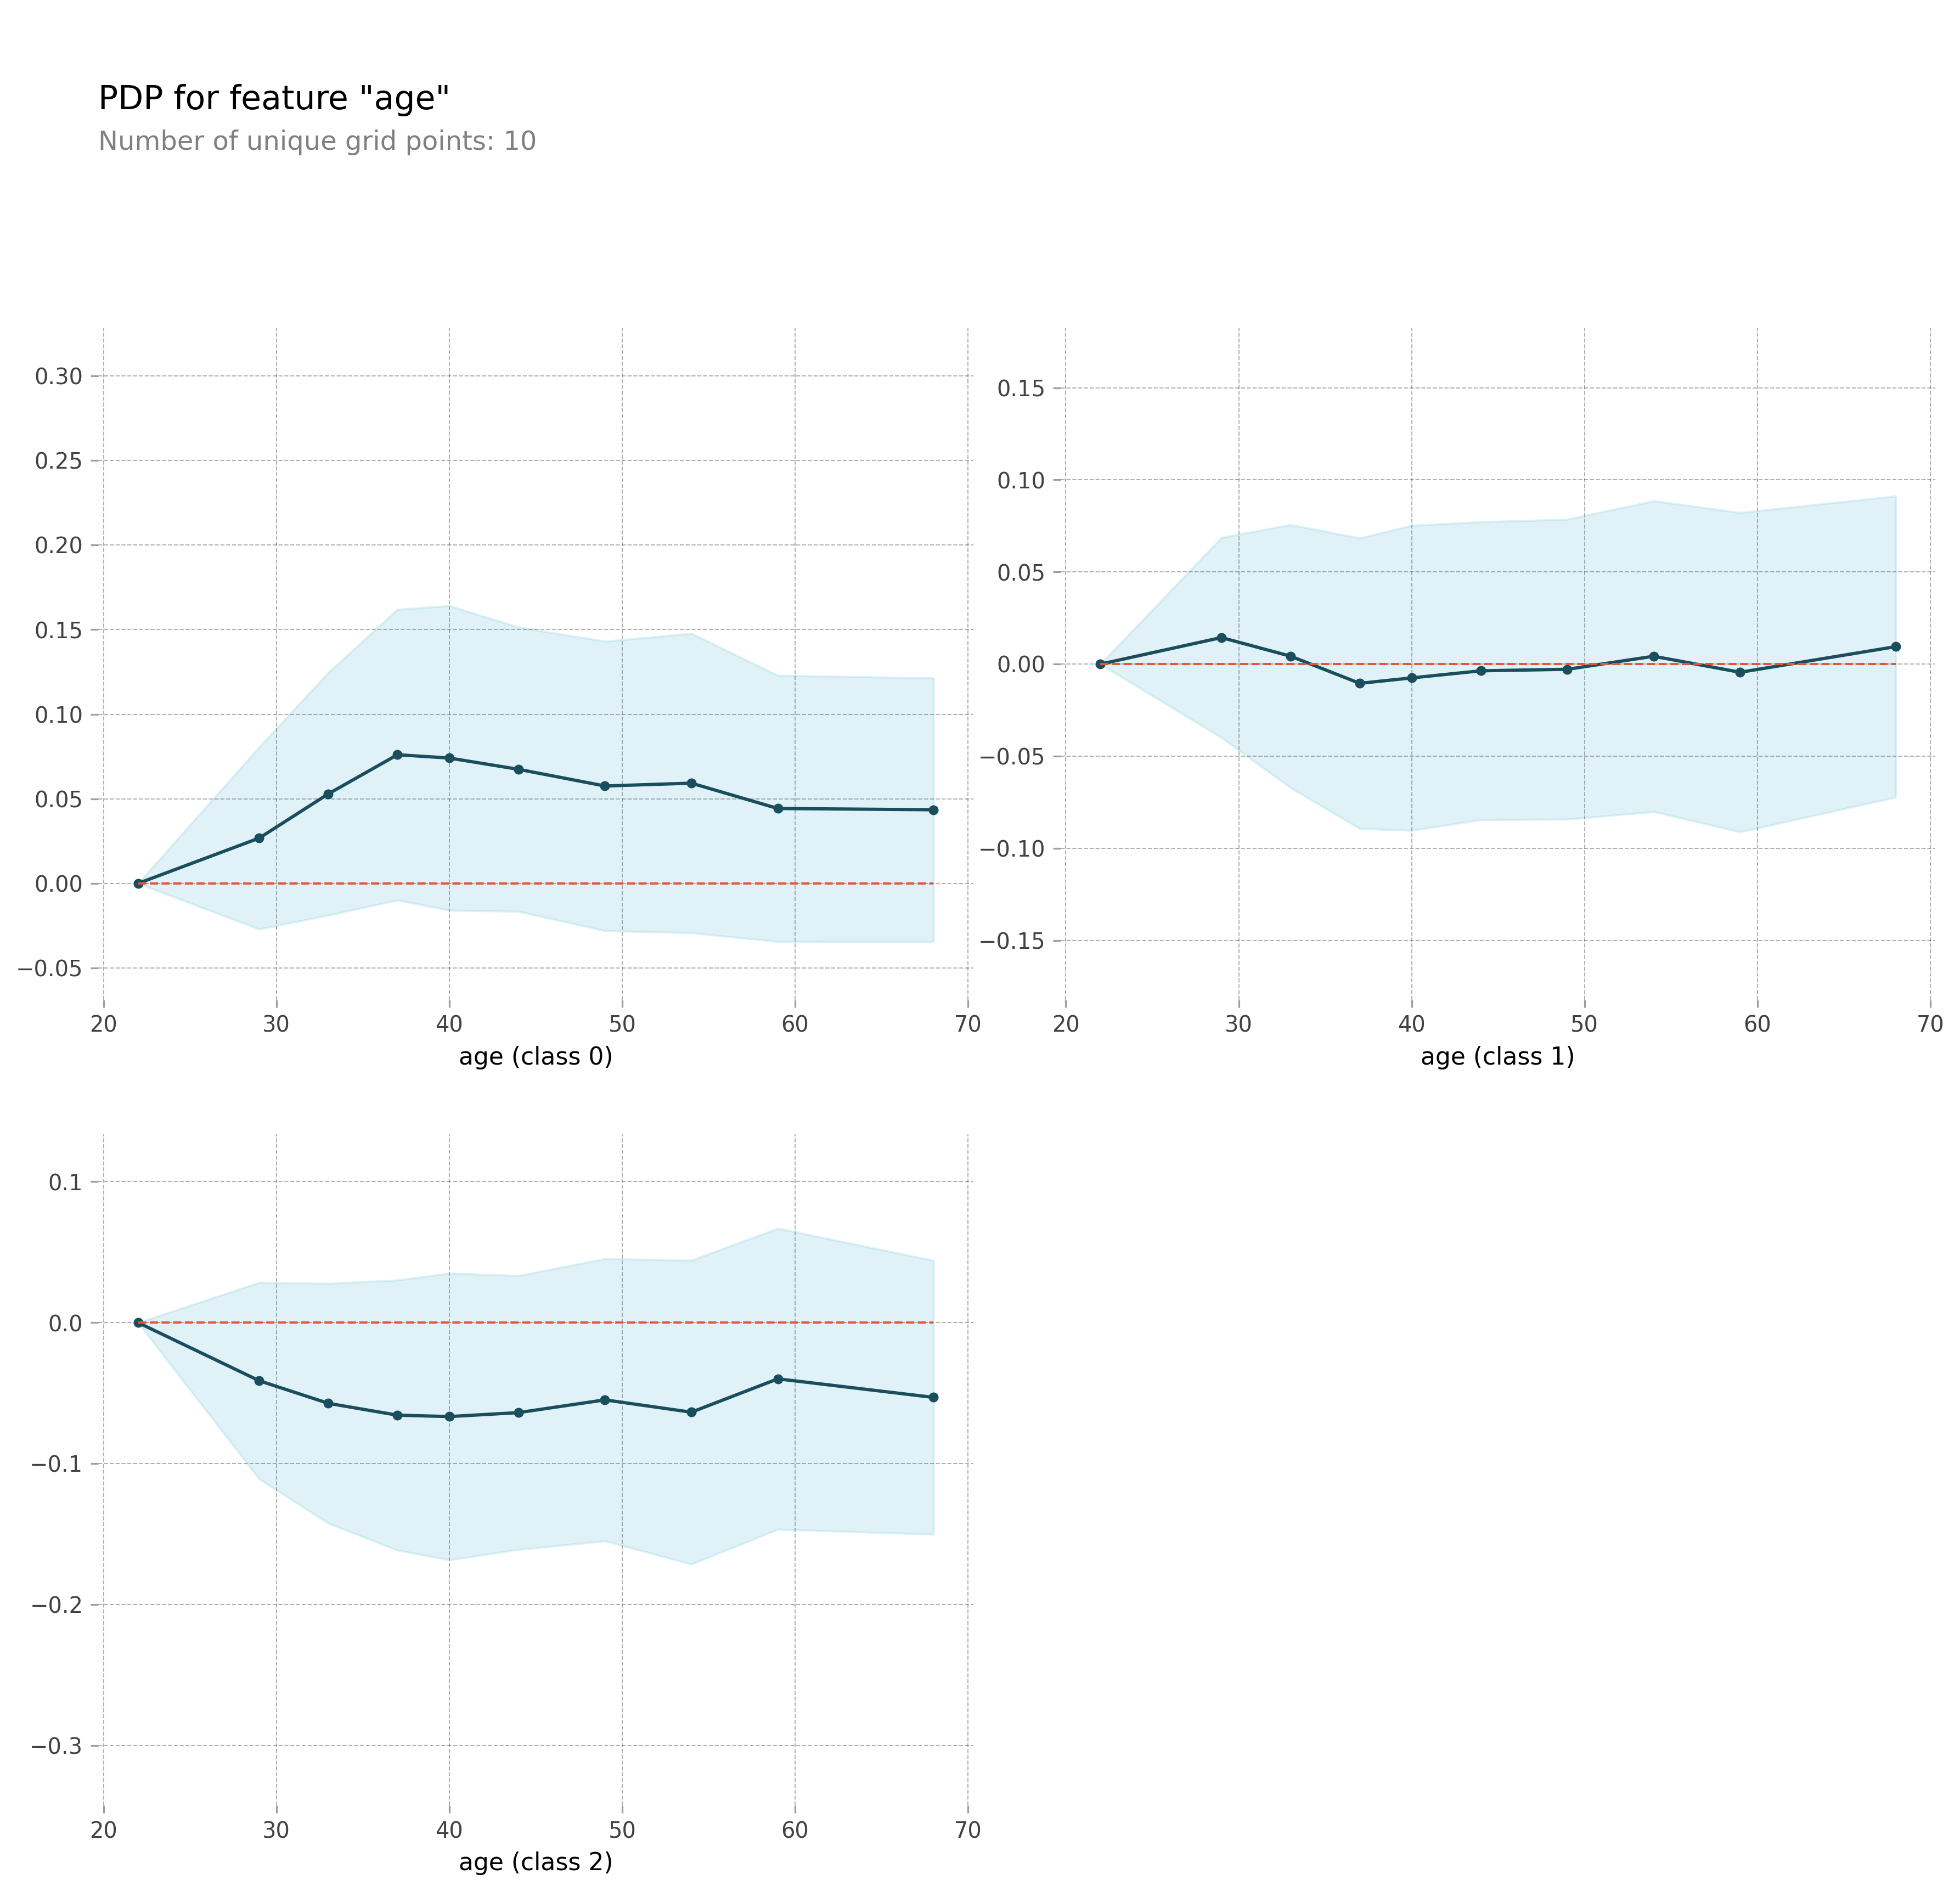

In [ ]:
feature = 'age'
isolated = pdp_isolate(
    model=model, 
    dataset=X_test_encoded.dropna(),  # 결측치가 채워지지 않은 샘플들을 드랍
    model_features=X_test.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_encoded.dropna())

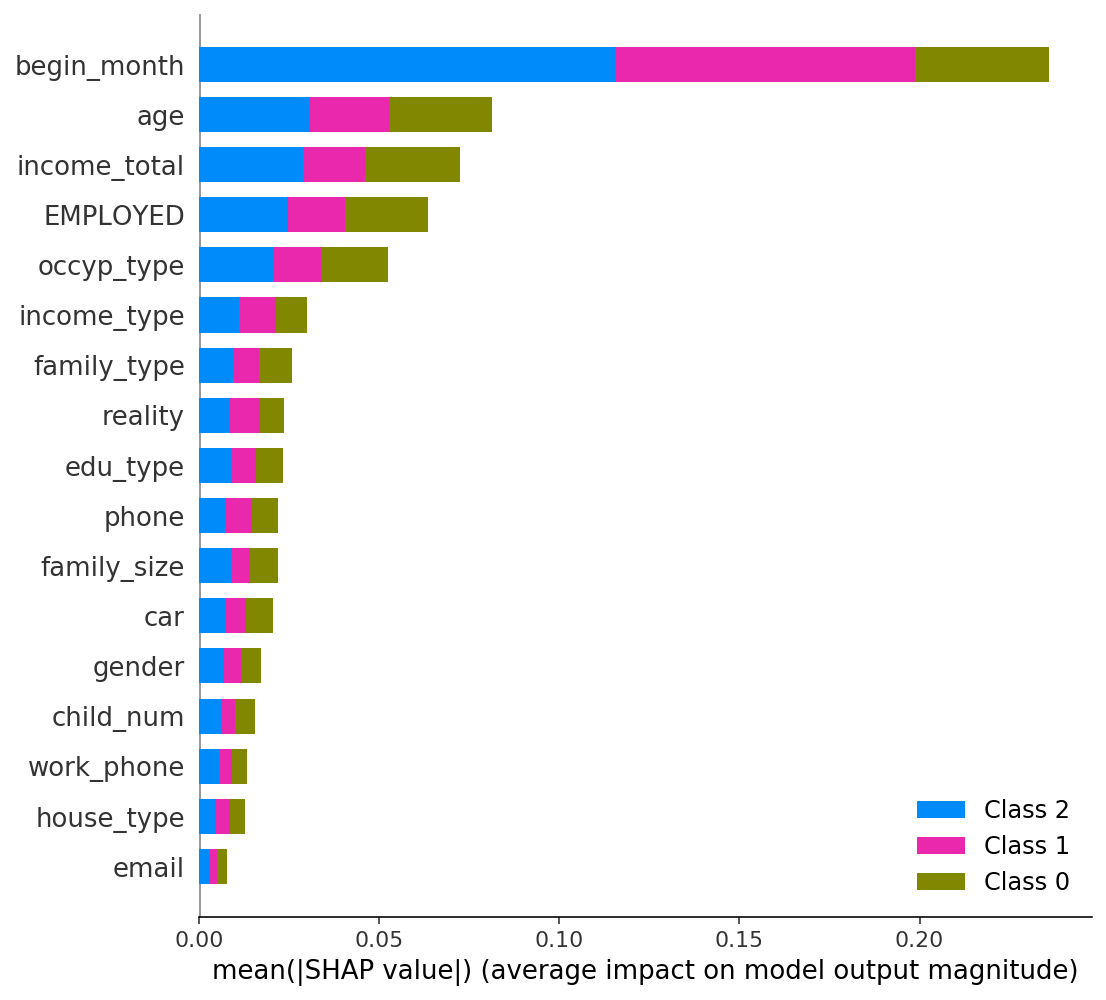

In [ ]:
shap.summary_plot(shap_values[:500], X_test_encoded.dropna().iloc[:1000], plot_type="bar")

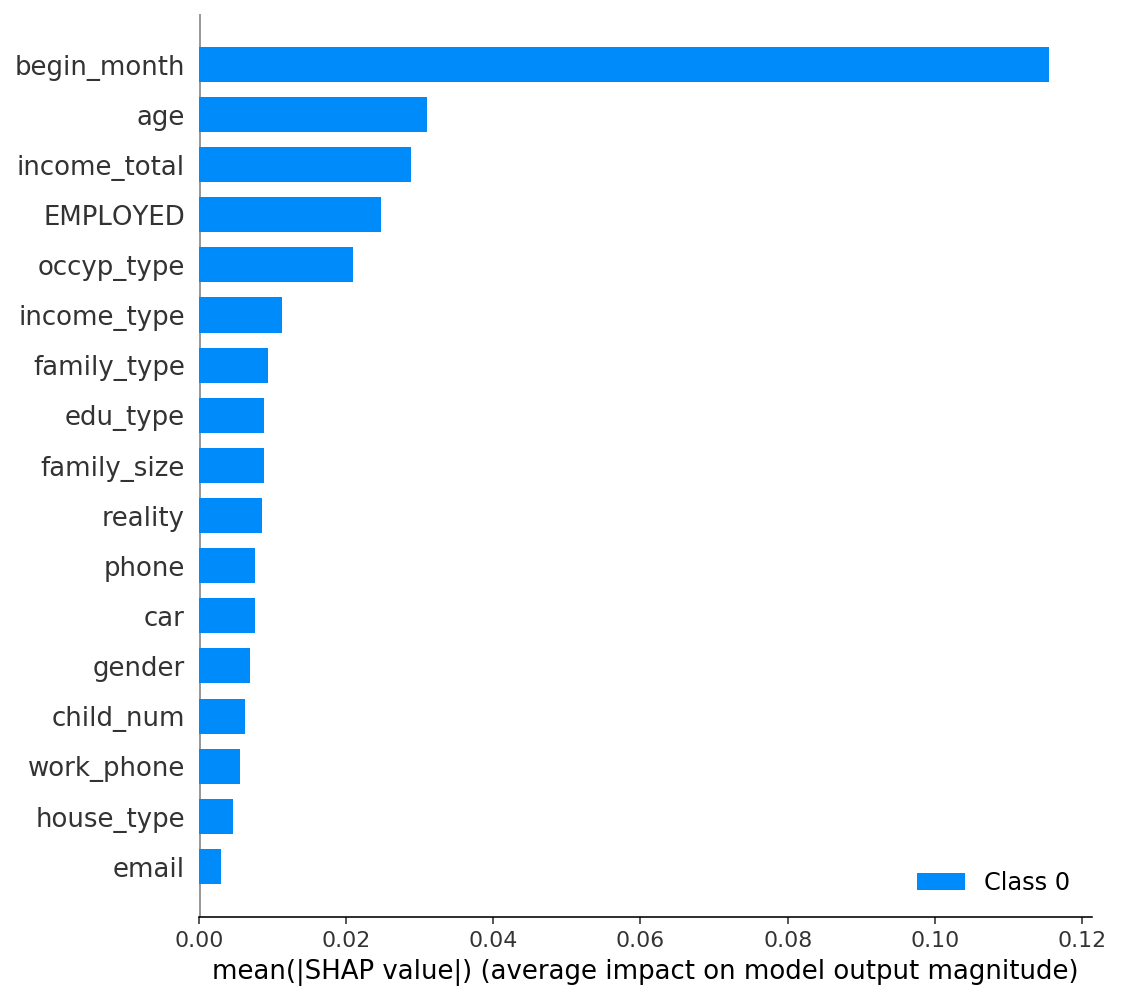

In [ ]:
shap.summary_plot(shap_values[2:500], X_val_encoded.dropna().iloc[2:500], plot_type="bar")

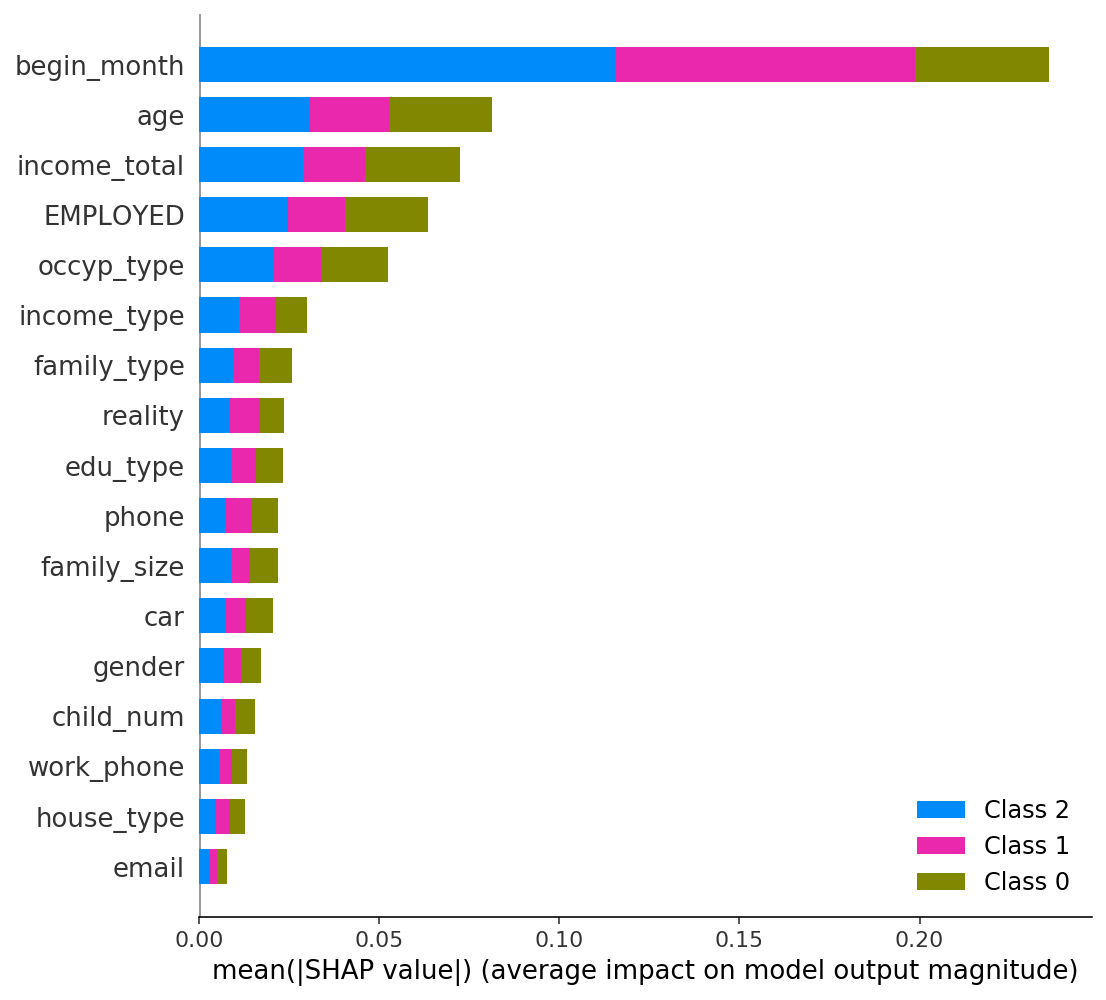

In [ ]:
shap.summary_plot(shap_values[0:500], X_val_encoded.dropna().iloc[0:500], plot_type="bar")

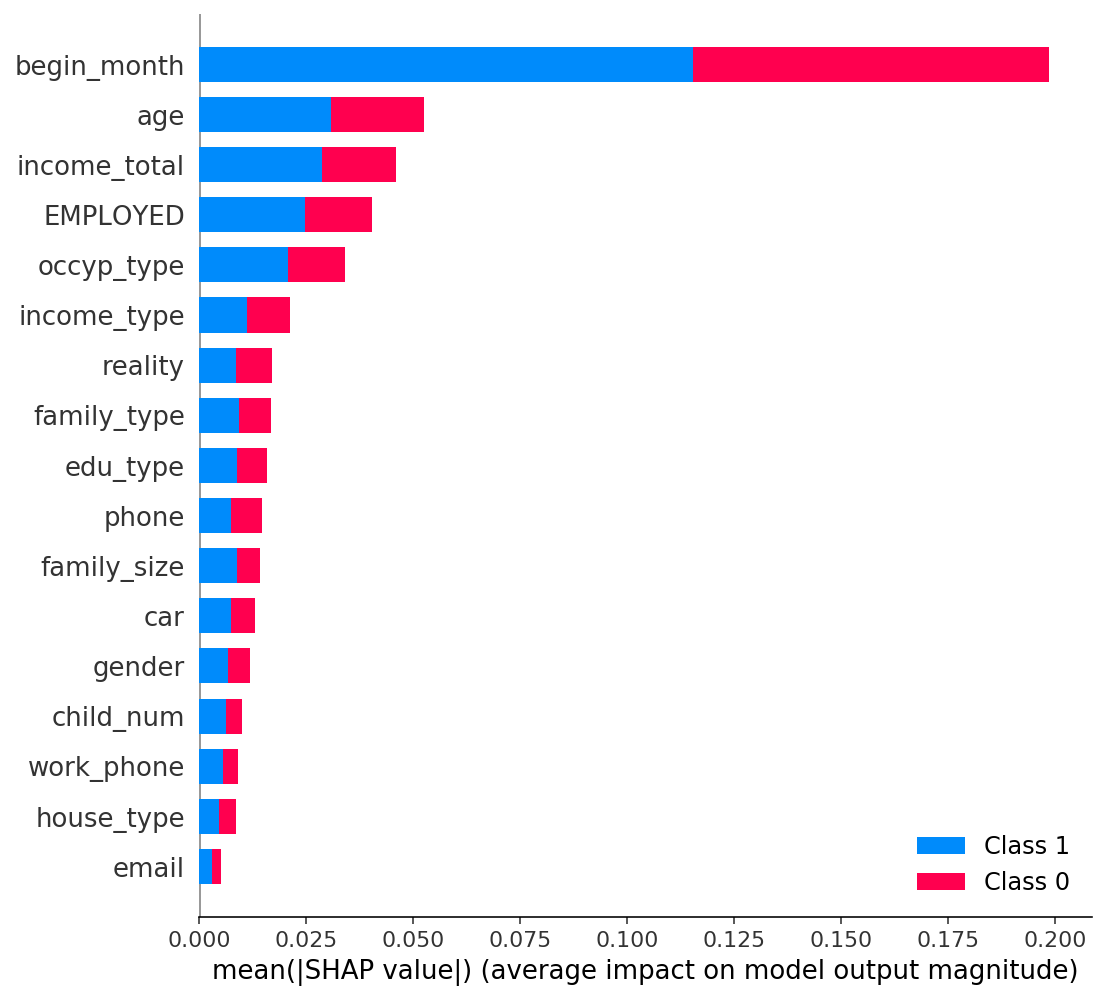

In [ ]:
shap.summary_plot(shap_values[1:500], X_val_encoded.dropna().iloc[1:500], plot_type="bar")

In [ ]:
shap.summary_plot(shap_values[:500], X_val_encoded.dropna().iloc[:500], plot_type="dot")

AssertionError: ignored

In [ ]:
row = X_val.iloc[[3]]
row

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,occyp_type,family_size,begin_month,EMPLOYED,age
5318,0,1,0,0,247500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,0,0,0,High skill tech staff,2.0,54.0,12,43


In [ ]:
explainer = shap.TreeExplainer(model)
row_processed =model.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

AttributeError: ignored

In [ ]:

# Permutation Importances

from eli5.sklearn import PermutationImportance
import eli5

permuter = PermutationImportance(
    model,
    random_state = 34
)

permuter.fit(X_test_encoded, y_test)

pd.Series(permuter.feature_importances_, X_test_encoded.columns).sort_values()
eli5.show_weights(permuter, top = None, feature_names = X_test_encoded.columns.tolist())

Weight,Feature
0.0705 ± 0.0092,begin_month
0.0056 ± 0.0039,income_total
0.0028 ± 0.0033,age
0.0002 ± 0.0050,car
-0.0002 ± 0.0030,EMPLOYED
-0.0003 ± 0.0041,work_phone
-0.0004 ± 0.0032,family_size
-0.0015 ± 0.0051,reality
-0.0017 ± 0.0031,phone
-0.0017 ± 0.0024,email


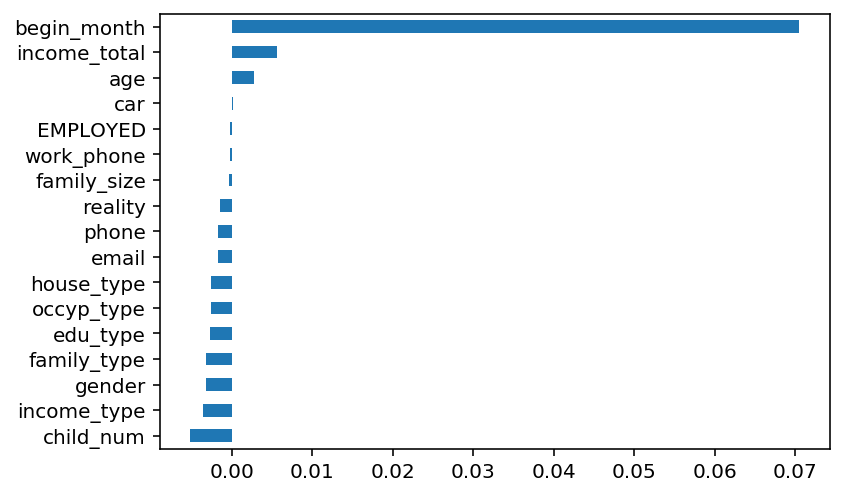

In [ ]:
pd.Series(permuter.feature_importances_, X_test_encoded.columns).sort_values().plot.barh();

우선 Permutation Importance를 이용하여 변수 중요도를 확인하였습니다.   
결과적으로 begin_month,income_total,age가 가장 중요한 변수임을 확인하였습니다.   